In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.reset_option('display.max_rows')
#from IPython.display import display
#with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
#    display(df)
pd.set_option('display.max_colwidth',150)


**Creating a cutout**

In [3]:
#the cutout is delimited by a border drawn between Outer Hebrides, Kattegat, Strait of Dover as well as Shetland and Orkney Islands

cutout = atlite.Cutout(path="north-sea-region-jan21.nc",
                       module="era5",
                       x=slice(-4.2600, 10.0000),
                       y=slice(51.4000, 60.8479),
                       time=slice("2021-01-15","2021-02-15") # until 25th of Jan: time=slice("2019-03-01","2019-03-31")
                       )


In [4]:
cutout.prepare()

INFO:atlite.data:Cutout already prepared.


<Cutout "north-sea-region-jan21">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.50 ⟷ 60.75, dy = 0.25
 time = 2021-01-15 ⟷ 2021-02-15, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [5]:
cutout.data
cutout.wind
cutout.prepared_features


<xarray.Dataset>
Dimensions:           (x: 58, y: 38, time: 768)
Coordinates:
  * x                 (x) float64 -4.25 -4.0 -3.75 -3.5 ... 9.25 9.5 9.75 10.0
  * y                 (y) float64 51.5 51.75 52.0 52.25 ... 60.25 60.5 60.75
  * time              (time) datetime64[ns] 2021-01-15 ... 2021-02-15T23:00:00
    lon               (x) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(38,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(38, 58), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['runoff', 'influx', 'wind', 'height', 'temperature']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-01-25 22:37:52 GMT by grib_to_netcdf-2.25.1: /op...

<bound method wind of <Cutout "north-sea-region-jan21">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.50 ⟷ 60.75, dy = 0.25
 time = 2021-01-15 ⟷ 2021-02-15, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']>

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                wnd_azimuth
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        influx           solar_altitude
        influx            solar_azimuth
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
dtype: object

**Importing country shapefiiles**

In [6]:
from shapely.geometry import Polygon
import geopandas

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
#Select the north sea bordering states
BorderingStates_init = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['United Kingdom', 'Denmark','Germany','Norway','France','Netherlands','Belgium']) 

cells = cutout.grid
projection = ccrs.Orthographic( -5,30)
country_bound = gpd.GeoSeries(cells.unary_union)

In [7]:
#BorderingStates_init.crs

**Plotting the cutout with abstract land borders**

(-4.375, 51.375, 10.125, 60.875)

<GeoAxesSubplot:>

<GeoAxesSubplot:>

<GeoAxesSubplot:>

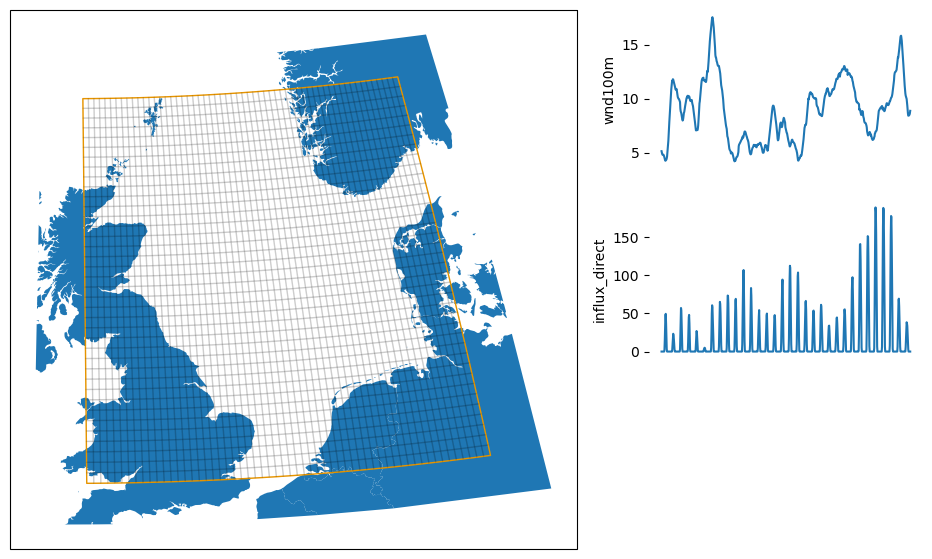

In [8]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig) 

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())

# we need to clip the predefined country border because they extend to Southern France and Svalbard

# a visual cutout of the north sea region is slightly larger than the actual cutout
display(cells.unary_union.bounds)
lat_point_list = [50.4,61.8479, 61.8479, 50.4,50.4]
lon_point_list = [-6.26, -6.26 , 12 ,12, -6.26 ]
polygon2 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf2 = gpd.GeoDataFrame([1], geometry=[polygon2], crs=cutout.grid.crs)
BorderingStates_init= BorderingStates_init.clip(poly_gdf2)

BorderingStates_init.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())

#ax.outline_patch.set_edgecolor('black') #deprecated?
ax.set_frame_on(True)
#a remnant of the tutorial: some weather data are plotted alongside
#so far, I want to keep the gridspec-layout
ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(['x', 'y']).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(['x', 'y']).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

#set_xlim und set_ylim funktionieren nicht 
#ax. set_extent([-4.375, 51.375, 10.125, 60.875],crs=geodetic()) auch nicht

**Plotting the windfarms from EMODNet with a map from OpenStreetMap**

Text(0.5, 1.0, 'First step: All wind farms of north sea bordering states')

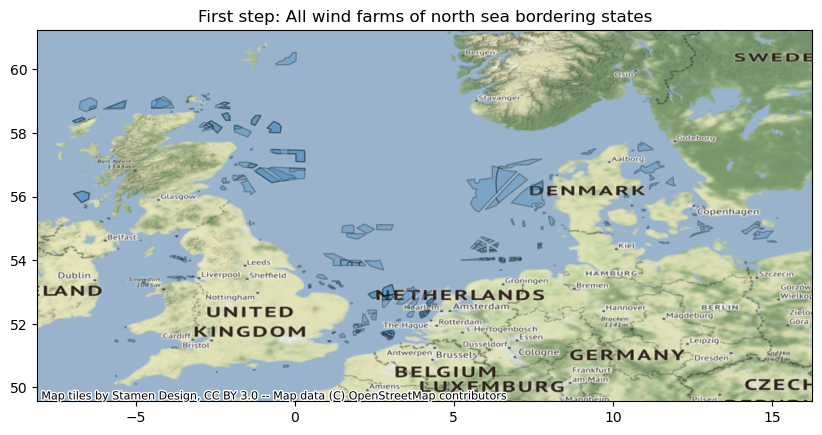

In [9]:
import contextily as cx

#data of European Offshore wind farms is imported
windfarm_map = gpd.read_file("../data/Windfarm-Shapefiles/EMODnet_HA_WindFarms_pg_20220324.shp")
# Firstly, we reduce the set to north sea bordering countries
windfarm_map=windfarm_map[windfarm_map["COUNTRY"].isin(['United Kingdom','Denmark','Belgium','Norway','Germany','Netherlands'])]

#France is also a potential bordering nation, but the potential site in the area (parc eolien dunkerque)
#is not comprised within the dataset
#it will not be built before 2024 anyway

#contextily chooses the right zoom factor automatically
ax = windfarm_map.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_map.crs) # der passende Ausschnitt wird zugewiesen
ax.set_title("First step: All wind farms of north sea bordering states")

#this would work, but not cartopy set-lim(minx,maxx,minym,maxy)
#ax.set_xlim(-1.2600, 5.0000)
#ax.set_ylim(50.4, 53.8)

#strangely the suggested method in the documentation does not work
#windfarm_map.to_crs(epsg=3857)
#fig, ax = plt.subplots (figsize = (15,15))
#windfarm_map.plot(ax=ax)
#cx.add_basemap(ax=ax,crs= 3857)
#cx.add_basemap(ax)


The data contains necessarily wind farms beyond the North Sea due to country as a selection criterion.

**Plot only windfarms, that are located in the cutout**

Index(['OBJECTID', 'COUNTRY', 'NAME', 'N_TURBINES', 'POWER_MW', 'STATUS',
       'YEAR', 'COAST_DIST', 'AREA_SQKM', 'NOTES', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

OBJECTID  COUNTRY              NAME  N_TURBINES  POWER_MW      STATUS  \
7          8  Belgium            Rentel          42    309.00  Production   
8          9  Belgium           Norther          44    370.00  Production   
9         10  Belgium           Seastar          30    252.00  Production   
10        11  Belgium           Mermaid          28    235.20  Production   
11        12  Belgium  C-Power (Zone A)          24    141.15  Production   

    YEAR    COAST_DIST  AREA_SQKM NOTES  Shape_Leng  Shape_Area  \
7   2018  28354.728982  23.264154  None    0.260649    0.003017   
8   2018  19797.758680  38.445331  None    0.352805    0.004979   
9   2020  36085.954019  18.426179  None    0.222749    0.002392   
10  2020  48314.549431  16.676150  None    0.208196    0.002169   
11  2013  24793.536916  10.682070  None    0.174694    0.001384   

                                                                                                                                                 geometry  
7   POLYGON ((2.88724 51.59085, 2.90552 51.59822, 2.91429 51.59965, 2.93139 51.60670, 2.93972 51.61086, 2.95537 51.61985, 3.00353 51.59084, 2.99282 51...  
8   POLYGON ((3.04002 51.51200, 2.97331 51.48950, 2.93681 51.51286, 2.94508 51.51529, 2.97299 51.52806, 2.97883 51.53398, 2.98698 51.53413, 2.99118 51...  
9   POLYGON ((2.86386 51.61521, 2.84370 51.60708, 2.83087 51.60788, 2.81428 51.61465, 2.81934 51.61971, 2.83984 51.63631, 2.85773 51.65052, 2.86800 51...  
10  POLYGON ((2.79057 51.71872, 2.78949 51.71814, 2.78900 51.71771, 2.78857 51.71722, 2.78790 51.71661, 2.78748 51.71613, 2.75580 51.71063, 2.75513 51...  
11                                 POLYGON ((2.88360 51.54680, 2.90836 51.55810, 2.96208 51.53428, 2.93766 51.52309, 2.92797 51.52018, 2.88360 51.54680))

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Second_step, All wind farms within the cutout')

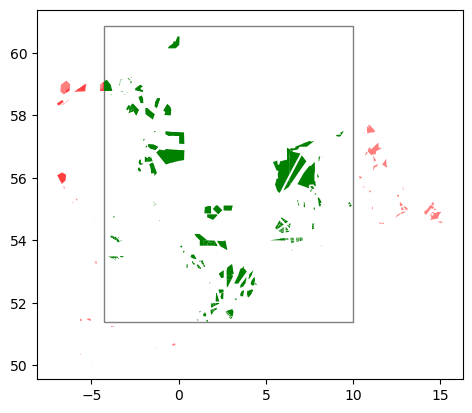

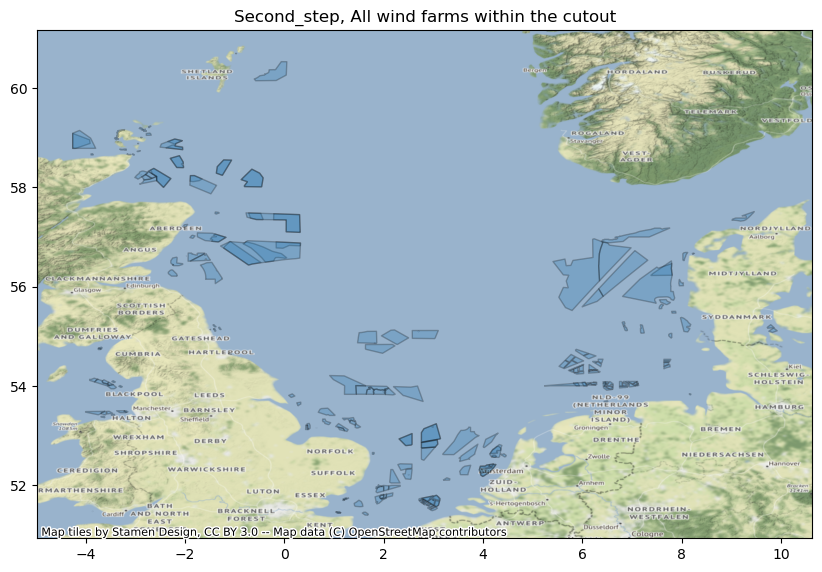

In [10]:
windfarm_map.columns
windfarm_map.head()

#take the polygon from the initial cutout and use it to reduce the initial country-based dataset
# a selection based on visual adherence to the region is not viable since the objectids have no geograpic correlation
#and the dataset containts more than 200 windfarms
lat_point_list = [51.4,60.8479, 60.8479,51.4,51.4]
lon_point_list = [-4.26, -4.26 , 10 ,10, -4.26 ]
polygon3 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf3 = gpd.GeoDataFrame([1], geometry=[polygon3], crs=windfarm_map.crs)

fig, (ax) = plt.subplots()
poly_gdf3.plot(ax=ax,color='white', edgecolor='grey')
windfarm_map.plot(ax=ax,zorder=0,color= 'red',alpha= 0.5)

windfarm_map_reduced = gpd.overlay(windfarm_map,poly_gdf3, how='intersection')
#that function also eliminates polygons outside of the scope of polygon 3 from our GeoPandas Dataframe
# but will also cut off border polygons 

#reindex took place automatically during overlay-method, else: df.reset_index()
#objectid serves as  unique identifiert
windfarm_map_reduced.plot(ax=ax,color='green')

#contextily plotting of windfarms on topographic map
ax = windfarm_map_reduced.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_map_reduced.crs) # der passende Ausschnitt wird zugewiesen
##ax.axis("off")
ax.set_title("Second_step, All wind farms within the cutout")

#display(windfarm_map_reduced)

**Discard windfarms, that are not located in the North Sea**

**i.e. off the coast of Cardif** : Bristol Channel <br> **in the Irish Sea** Liverpool Bay and Morecambe Bay

(224, 14)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Step Three: Exclusion of windfarms in Irish Sea/Cornwall and Baltic Sea')

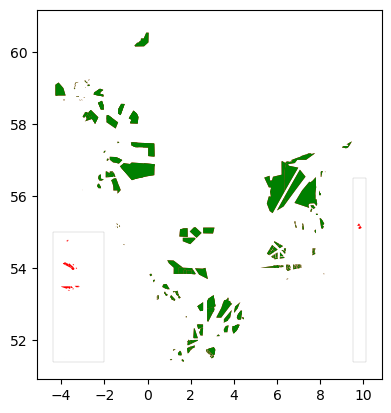

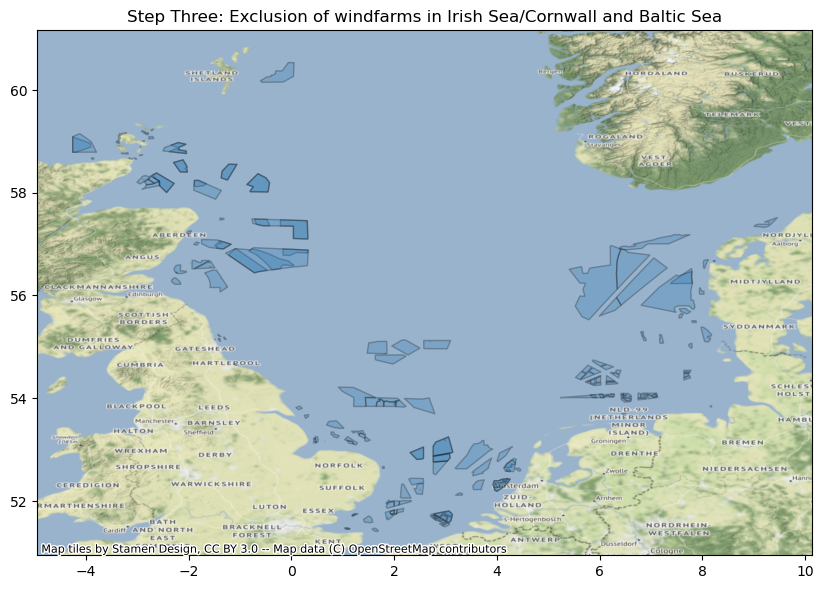

In [11]:

windfarm_map_reduced.shape

#define areas that are to be discarded
#again: selection is done by polygons instead of hand-selecting
xmin,ymin,xmax,ymax= cells.total_bounds

#Irish Sea
lat_point_list = [ymin,55.0, 55.0,ymin,ymin]
lon_point_list = [xmin, xmin , -2 ,-2, xmin ]
polygon4 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf_excl_west = gpd.GeoDataFrame([1], geometry=[polygon4], crs=windfarm_map_reduced.crs)

#Baltic Sea
lat_point_list = [ymin,56.5, 56.5,ymin,ymin]
lon_point_list = [9.5, 9.5 , xmax ,xmax, 9.5 ]
polygon5 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf_excl_east = gpd.GeoDataFrame([1], geometry=[polygon5], crs=windfarm_map_reduced.crs)

#within-function demands a gp-series, the argument needs to be a shapely-object
bool1= windfarm_map_reduced.within(polygon4) #ergibt eine Boolean-Tabelle
bool2= windfarm_map_reduced.within(polygon5)
#use boolean logic to create a mask that excludes both areas
bool3= bool1 + bool2

#windfarm_map_reduced
#use boolean filtering
windfarm_new= windfarm_map_reduced[~bool3.values]

#windfarm_map_reduced = windfarm_map_reduced[windfarm_map_reduced.within(polygon3) ==False]

fig,ax1 =plt.subplots()

windfarm_map_reduced.plot(ax=ax1,color='red',zorder=0)
windfarm_new.plot(ax=ax1,color='green')
poly_gdf_excl_east.plot(ax=ax1,color='none',edgecolor='grey',linewidth=0.15)
poly_gdf_excl_west.plot(ax=ax1,color='none',edgecolor='grey',linewidth=0.15)

#contextily plotting of windfarms on topographic map
ax = windfarm_new.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_new.crs) # der passende Ausschnitt wird zugewiesen
##ax.axis("off")
ax.set_title("Step Three: Exclusion of windfarms in Irish Sea/Cornwall and Baltic Sea")
#




In [12]:

windfarm_new.reset_index(drop=True, inplace=True)
windfarm_new.shape
pd.set_option('display.max_rows', 1000)

windfarm_new


(204, 14)

OBJECTID         COUNTRY  \
0           8         Belgium   
1           9         Belgium   
2          10         Belgium   
3          11         Belgium   
4          12         Belgium   
5          13         Belgium   
6          14         Belgium   
7          15         Belgium   
8          16         Belgium   
9          17         Belgium   
10         18         Belgium   
11         19         Germany   
12         20         Germany   
13         21         Germany   
14         24         Germany   
15         25         Germany   
16         26         Germany   
17         27         Germany   
18         28         Germany   
19         29         Germany   
20         30         Germany   
21         31         Germany   
22         32         Germany   
23         33         Germany   
24         34         Germany   
25         35         Germany   
26         36         Germany   
27         37         Germany   
28         38         Germany   
29         39         Germany   
30         40         Germany   
31         41         Germany   
32         42         Germany   
33         43         Germany   
34         44         Germany   
35         45         Germany   
36         46         Germany   
37         47         Germany   
38         48         Germany   
39         49         Germany   
40         50         Germany   
41         51         Germany   
42         52         Germany   
43         63  United Kingdom   
44         65  United Kingdom   
45         68  United Kingdom   
46         69  United Kingdom   
47         70  United Kingdom   
48         71  United Kingdom   
49         72  United Kingdom   
50         73  United Kingdom   
51         74  United Kingdom   
52         75  United Kingdom   
53         76  United Kingdom   
54         77  United Kingdom   
55         78  United Kingdom   
56         79  United Kingdom   
57         81  United Kingdom   
58         82  United Kingdom   
59         85  United Kingdom   
60         88  United Kingdom   
61         89  United Kingdom   
62         90  United Kingdom   
63         91  United Kingdom   
64         92  United Kingdom   
65         93  United Kingdom   
66         96  United Kingdom   
67         97  United Kingdom   
68         98  United Kingdom   
69        109  United Kingdom   
70        110  United Kingdom   
71        115  United Kingdom   
72        119  United Kingdom   
73        120  United Kingdom   
74        128  United Kingdom   
75        129  United Kingdom   
76        130  United Kingdom   
77        131  United Kingdom   
78        132  United Kingdom   
79        133  United Kingdom   
80        134  United Kingdom   
81        135  United Kingdom   
82        136  United Kingdom   
83        137  United Kingdom   
84        138  United Kingdom   
85        139  United Kingdom   
86        140  United Kingdom   
87        141  United Kingdom   
88        142  United Kingdom   
89        143  United Kingdom   
90        144  United Kingdom   
91        145  United Kingdom   
92        146  United Kingdom   
93        147  United Kingdom   
94        148  United Kingdom   
95        149  United Kingdom   
96        150  United Kingdom   
97        151  United Kingdom   
98        152  United Kingdom   
99        153  United Kingdom   
100       154  United Kingdom   
101       155  United Kingdom   
102       156  United Kingdom   
103       157  United Kingdom   
104       158  United Kingdom   
105       159  United Kingdom   
106       160  United Kingdom   
107       161  United Kingdom   
108       162  United Kingdom   
109       163  United Kingdom   
110       164  United Kingdom   
111       165  United Kingdom   
112       166  United Kingdom   
113       167  United Kingdom   
114       168  United Kingdom   
115       169  United Kingdom   
116       170  United Kingdom   
117       171  United Kingdom   
118       172  United Kingdom   
119       173  United Kingdom   
120       17

**Reading in  **

In [13]:
turbines_atlite= [t for t in atlite.windturbines] #list comprehension                    
turbines_atlite =pd.Series(turbines_atlite)
turbines_atlite
#for t in atlite.windturbines: print(f'* {t}') #displaying all built-in turbines

#if turbines have been imported, their name will show up here

0                                 Bonus_B1000_1000kW
1                                Enercon_E101_3000kW
2                                Enercon_E126_7500kW
3                                 Enercon_E82_3000kW
4     NREL_ReferenceTurbine_2016CACost_10MW_offshore
5      NREL_ReferenceTurbine_2016CACost_6MW_offshore
6      NREL_ReferenceTurbine_2016CACost_8MW_offshore
7     NREL_ReferenceTurbine_2019ORCost_12MW_offshore
8     NREL_ReferenceTurbine_2019ORCost_15MW_offshore
9        NREL_ReferenceTurbine_2020ATB_12MW_offshore
10       NREL_ReferenceTurbine_2020ATB_15MW_offshore
11       NREL_ReferenceTurbine_2020ATB_18MW_offshore
12                 NREL_ReferenceTurbine_2020ATB_4MW
13               NREL_ReferenceTurbine_2020ATB_5.5MW
14                 NREL_ReferenceTurbine_2020ATB_7MW
15                NREL_ReferenceTurbine_5MW_offshore
16                            Siemens_SWT_107_3600kW
17                                Siemens_SWT_2300kW
18                                 Suzlon_S82_

Horns Rev 2 turbine type:Siemens SWT-2.3-93 source: https://www.thewindpower.net/windfarm_de_7064_horns-rev-2.php

New Turbine Power curves can be found under: https://openenergy-platform.org/dataedit/view/supply/wind_turbine_library
An ATLITE command imports these for further processing

In [14]:
used_turbines= pd.DataFrame(data=windfarm_new[['OBJECTID','COUNTRY','NAME','STATUS']])
len(used_turbines)
windfarm_new.iloc[15,1]


204

'Germany'

In [15]:
import requests
import numpy as np
OEDB_URL = "https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows"

# Cache turbine request locally

# Get the turbine list
result = requests.get(OEDB_URL)
# Convert JSON to dataframe for easier filtering
# Only consider turbines with power curves available
df = pd.DataFrame.from_dict(result.json())
oedb_turbines = df[df.has_power_curve]

In [16]:
#df
oedb_turbines.shape
oedb_turbines_mask = df[['id']].isin(oedb_turbines)
oedb_turbines_mask.rename({'id':'has_power_curve'},axis=1,inplace=True)
oedb_turbines_mask
oedb_turbines_mask.value_counts()
oedb_turbines_mask.sum()



(68, 25)

has_power_curve
0               True
1               True
2               True
3               True
4               True
5               True
6               True
7              False
8              False
9              False
10              True
11              True
12              True
13              True
14              True
15              True
16              True
17             False
18             False
19             False
20             False
21              True
22              True
23              True
24             False
25             False
26              True
27             False
28              True
29              True
30              True
31             False
32             False
33             False
34             False
35             False
36             False
37             False
38             False
39             False
40              True
41             False
42             False
43             False
44             False
45             False
46             False
47             False
48             False
49              True
50             False
51             False
52             False
53              True
54              True
55              True
56             False
57             False
58              True
59              True
60              True
61              True
62             False
63              True
64             False
65             False
66              True
67              True
68              True
69              True
70             False
71             False
72             False
73             False
74             False
75              True
76              True
77             False
78              True
79              True
80             False
81             False
82              True
83             False
84             False
85             False
86             False
87             False
88              True
89             False
90             False
91             False
92             False
93             False
94             False
95              True
96             False
97              True
98             False
99             False
100             True
101            False
102            False
103             True
104             True
105            False
106            False
107             True
108             True
109             True
110             True
111            False
112            False
113            False
114             True
115            False
116             True
117             True
118             True
119            False
120             True
121            False
122             True
123            False
124            False
125            False
126            False
127             True
128             True
129            False
130            False
131             True
132             True
133             True
134             True
135             True
136             True
137             True
138             True
139             True
140             True

has_power_curve
False              73
True               68
dtype: int64

has_power_curve    68
dtype: int64

In [17]:
#goal: have a list of all turbines in the external source, so that I can add these manually in a .xlsx to each North Sea windpark

pd.set_option('display.max_rows',1000)

new_turbines= pd.read_csv("..\data\supply__wind_turbine_library.csv")
#name, turbine_name , turbiney_type vary greatly; often name components are missing, so addition of all strings
#turbine_ids are not sorted in the original file
#ids are retained, in case I want to use the specific turbine type
new_turbines['agg_name'] = new_turbines['manufacturer'].fillna('') + ' ' +new_turbines['name'].fillna('') +' ' + new_turbines['turbine_type'].fillna('')
#adding both lists
new_turbines1= pd.concat([new_turbines['agg_name'], turbines_atlite],axis=0,ignore_index=True)

new_turbines2= pd.concat([new_turbines['id'].astype(str),new_turbines1],axis=1,ignore_index=True)
new_turbines2.rename(columns={0: "id", 1: "new_name"},inplace=True)

#there are duplicates in this list, due to incoherent naming
#if ATLITE uses the suppl__Wind_turbine__library.csv , it might have a way to deal with that?

In [18]:


#adding an empty column for manual entries
#adding the list of possible turbines for excel-function data validation/drop-down menü
#adding a mask, whether the OEDB-entry has a power curve, which is filtered by the subsequent get_oedb_windturbineconfig anyway
used_turbines= pd.concat([used_turbines,pd.DataFrame({'TURBINE_TYPE' : []}),new_turbines2,oedb_turbines_mask],axis=1)
used_turbines

OBJECTID         COUNTRY  \
0           8         Belgium   
1           9         Belgium   
2          10         Belgium   
3          11         Belgium   
4          12         Belgium   
5          13         Belgium   
6          14         Belgium   
7          15         Belgium   
8          16         Belgium   
9          17         Belgium   
10         18         Belgium   
11         19         Germany   
12         20         Germany   
13         21         Germany   
14         24         Germany   
15         25         Germany   
16         26         Germany   
17         27         Germany   
18         28         Germany   
19         29         Germany   
20         30         Germany   
21         31         Germany   
22         32         Germany   
23         33         Germany   
24         34         Germany   
25         35         Germany   
26         36         Germany   
27         37         Germany   
28         38         Germany   
29         39         Germany   
30         40         Germany   
31         41         Germany   
32         42         Germany   
33         43         Germany   
34         44         Germany   
35         45         Germany   
36         46         Germany   
37         47         Germany   
38         48         Germany   
39         49         Germany   
40         50         Germany   
41         51         Germany   
42         52         Germany   
43         63  United Kingdom   
44         65  United Kingdom   
45         68  United Kingdom   
46         69  United Kingdom   
47         70  United Kingdom   
48         71  United Kingdom   
49         72  United Kingdom   
50         73  United Kingdom   
51         74  United Kingdom   
52         75  United Kingdom   
53         76  United Kingdom   
54         77  United Kingdom   
55         78  United Kingdom   
56         79  United Kingdom   
57         81  United Kingdom   
58         82  United Kingdom   
59         85  United Kingdom   
60         88  United Kingdom   
61         89  United Kingdom   
62         90  United Kingdom   
63         91  United Kingdom   
64         92  United Kingdom   
65         93  United Kingdom   
66         96  United Kingdom   
67         97  United Kingdom   
68         98  United Kingdom   
69        109  United Kingdom   
70        110  United Kingdom   
71        115  United Kingdom   
72        119  United Kingdom   
73        120  United Kingdom   
74        128  United Kingdom   
75        129  United Kingdom   
76        130  United Kingdom   
77        131  United Kingdom   
78        132  United Kingdom   
79        133  United Kingdom   
80        134  United Kingdom   
81        135  United Kingdom   
82        136  United Kingdom   
83        137  United Kingdom   
84        138  United Kingdom   
85        139  United Kingdom   
86        140  United Kingdom   
87        141  United Kingdom   
88        142  United Kingdom   
89        143  United Kingdom   
90        144  United Kingdom   
91        145  United Kingdom   
92        146  United Kingdom   
93        147  United Kingdom   
94        148  United Kingdom   
95        149  United Kingdom   
96        150  United Kingdom   
97        151  United Kingdom   
98        152  United Kingdom   
99        153  United Kingdom   
100       154  United Kingdom   
101       155  United Kingdom   
102       156  United Kingdom   
103       157  United Kingdom   
104       158  United Kingdom   
105       159  United Kingdom   
106       160  United Kingdom   
107       161  United Kingdom   
108       162  United Kingdom   
109       163  United Kingdom   
110       164  United Kingdom   
111       165  United Kingdom   
112       166  United Kingdom   
113       167  United Kingdom   
114       168  United Kingdom   
115       169  United Kingdom   
116       170  United Kingdom   
117       171  United Kingdom   
118       172  United Kingdom   
119       173  United Kingdom   
120       17

**Writing a preliminary Mini-Database to Excel-File**

In [19]:
#this file already exists, new entries are entered into the copy \WiP_Eingabe_Turbinen.xlsx
#used_turbines.to_excel(r"C:\Users\march\Desktop\oweg-int-NSR\data\Turbine_types.xlsx" ,sheet_name="Sheet1")

In [20]:
#an example how the ATLITE method collects new windturbines from open energy platform
#but will only request turbines that have a power curve
from atlite.resource import get_oedb_windturbineconfig
get_oedb_windturbineconfig(id=52)

#from the API
#atlite.resource.get_windturbineconfig("Siemens_SWT_2300kW") #preinstalled 
#this method can be combined with oedb /  
#atlite.resource.get_windturbineconfig("oedb:V112-3.0 MW") #requested from oedb: one needs the "name" attribute from the table

#get_oedb_windturbineconfig(manufacturer="Nordex")

#an error message for "Nordex" is to be expected since there are multiple entries with

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='52'.


{'name': 'V112/3000',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.023, 0.068, 0.13 , 0.206, 0.301, 0.418, 0.557, 0.72 , 0.912,
        1.13 , 1.377, 1.654, 1.954, 2.272, 2.572, 2.808, 2.988, 3.046,
        3.065, 3.073, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075]),
 'P': 3.075}

In [21]:
#from atlite.resource import get_oedb_windturbineconfig
#works_list= []
#new_list=[]
#for i in list(range(141)):
#    
#    try: get_oedb_windturbineconfig(i)
#    except:new_list.append(i) 
#    print(i)    
#print(new_list)

**Reference data from the ENTSOE-API**

In [22]:
import pandas as pd
#farms_be= pd.read_csv("..\data\BEoutfile.csv")
#farms_dk = pd.read_csv("..\data\DK_CAoutfile.csv")
#farms_gb= pd.read_csv("..\data\GBoutfile.csv")
##EIC_list = pd.read_excel(r"..\data\GB Electric EIC Library (External) upda.xlsx", sheet_name='ESO W Type Codes - BMUs')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#these data wre obtained via the ENTSOE-API
#farms_be= pd.read_csv("..\data\BE_1_outfile.csv")
#farms_dk = pd.read_csv("..\data\DK_CA_1_outfile.csv")
#farms_gb= pd.read_csv("..\data\GB_1_outfile.csv")
farms_be= pd.read_csv("..\data\BE_4_outfile.csv")
farms_dk = pd.read_csv("..\data\DK_CA_4_outfile.csv")
farms_gb= pd.read_csv("..\data\GB_4_outfile.csv")
EIC_list = pd.read_excel(r"..\data\GB Electric EIC Library (External) upda.xlsx", sheet_name='ESO W Type Codes - BMUs')

farms_be = farms_be.rename({'Unnamed: 0': 'TimeIndex'}, axis=1) 
farms_gb = farms_gb.rename({'Unnamed: 0': 'TimeIndex'}, axis=1) 
farms_dk = farms_dk.rename({'Unnamed: 0': 'TimeIndex'}, axis=1) 

#remove the first two columns, because they contain descriptors
###use timestamps as Index

 #Horns Rev 3 did not exist before August 2019
farms_dk.drop(labels=[0,1], axis=0,inplace=True)
farms_dk['TimeIndex'] = pd.to_datetime(farms_dk['TimeIndex'],utc=True) #resample only works on a DateTimeIndex
farms_dk = farms_dk.set_index('TimeIndex')
farms_dk = farms_dk.astype(float) #does not change the dtype of the index '#this assignment is necessary, since all values were read in as Strings

farms_be.drop(labels=[0,1], axis=0,inplace=True)
farms_be.set_index('TimeIndex',inplace=True) #other way around works too
farms_be.index = pd.to_datetime(farms_be.index,utc=True)
#type(farms_be.index)
farms_be = farms_be.astype(float) 


#British wind farms need to be translated via the EIC
#list  available at: https://www.nationalgrideso.com/document/167131/download
#EIC_list.head()
abbrev_list= farms_gb.columns.tolist()
translation_list = []
#for abbrev in abbrev_list:
    #translation_list.append((abbrev,EIC_list[EIC_list['Display Name']==abbrev]['EIC Name - Asset Name'].to_string(index=False)))
    
translation_dict = {abbrev : EIC_list[EIC_list['Display Name']==abbrev]['EIC Name - Asset Name'].to_string(index=False) for abbrev in abbrev_list}
#translation_list is a dictionary of abbreviation an actual name
translation_dict

pd.reset_option('display.max_rows')

farms_gb.drop(labels=[0,1], axis=0,inplace=True)
farms_gb['TimeIndex'] = pd.to_datetime(farms_gb['TimeIndex'],utc=True) #resample only works on a DateTimeIndex
farms_gb = farms_gb.set_index('TimeIndex')
farms_gb.index

#only british data are half-hourly
farms_gb = farms_gb.astype(float) 
farms_gb=farms_gb.resample('1H').mean()

#the translation list includes offshore windfarms in the Irish sea

{'TimeIndex': 'Series([], )',
 'ABRBO-1': 'Aberdeen Offshore Wind Farm',
 'BEATO-1': 'Beatrice Offshore Wind Farm ',
 'BEATO-2': 'Beatrice Offshore Wind Farm ',
 'BEATO-3': 'Beatrice Offshore Wind Farm ',
 'BEATO-4': 'Beatrice Offshore Wind Farm ',
 'BOWLW-1': 'Barrow Offshore Wind Farm BOWLW-1',
 'BRBEO-1': 'Burbo Extension BRBEO-1',
 'BURBW-1': 'Burbo Wind Farm BURBW-1',
 'DDGNO-1': 'Dudgeon Offshore Wind Farm DDGNO-1',
 'DDGNO-2': 'Dudgeon Offshore Wind Farm DDGNO-2',
 'DDGNO-3': 'Dudgeon Offshore Wind Farm DDGNO-3',
 'DDGNO-4': 'Dudgeon Offshore Wind Farm DDGNO-4',
 'EAAO-1': 'Series([], )',
 'EAAO-2': 'East Anglia One',
 'GAOFO-1': 'Galloper Offshore Wind Farm GAOFO-1',
 'GAOFO-2': 'Galloper Offshore Wind Farm GAOFO-2',
 'GAOFO-3': 'Galloper Offshore Wind Farm GAOFO-3',
 'GAOFO-4': 'Galloper Offshore Wind Farm GAOFO-4',
 'GNFSW-1': 'Gunfleet Sands GNFSW-1',
 'GNFSW-2': 'Gunfleet Sands GNFSW-2',
 'GRGBW-1': 'Greater Gabbard GRGBW-1',
 'GRGBW-2': 'Greater Gabbard GRGBW-2',
 'GRGBW-3

DatetimeIndex(['2021-01-15 00:00:00+00:00', '2021-01-15 00:30:00+00:00',
               '2021-01-15 01:00:00+00:00', '2021-01-15 01:30:00+00:00',
               '2021-01-15 02:00:00+00:00', '2021-01-15 02:30:00+00:00',
               '2021-01-15 03:00:00+00:00', '2021-01-15 03:30:00+00:00',
               '2021-01-15 04:00:00+00:00', '2021-01-15 04:30:00+00:00',
               ...
               '2021-02-15 19:00:00+00:00', '2021-02-15 19:30:00+00:00',
               '2021-02-15 20:00:00+00:00', '2021-02-15 20:30:00+00:00',
               '2021-02-15 21:00:00+00:00', '2021-02-15 21:30:00+00:00',
               '2021-02-15 22:00:00+00:00', '2021-02-15 22:30:00+00:00',
               '2021-02-15 23:00:00+00:00', '2021-02-15 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='TimeIndex', length=1536, freq=None)

In [23]:
farms_dk
#o = farms_dk['Horns Rev B']
#p = farms_gb['HOWAO-2']
#q = farms_be['Rentel Offshore WP']



Anholt  Horns Rev A  Horns Rev B  Horns Rev C  \
TimeIndex                                                                  
2021-01-15 00:00:00+00:00   151.0         27.0         50.0        104.0   
2021-01-15 01:00:00+00:00   210.0         11.0         55.0         79.0   
2021-01-15 02:00:00+00:00   337.0          2.0         26.0         45.0   
2021-01-15 03:00:00+00:00   350.0          6.0         20.0         31.0   
2021-01-15 04:00:00+00:00   267.0          6.0          8.0         16.0   
...                           ...          ...          ...          ...   
2021-02-15 19:00:00+00:00   362.0         21.0         19.0         75.0   
2021-02-15 20:00:00+00:00   360.0          8.0          5.0         35.0   
2021-02-15 21:00:00+00:00   331.0         18.0         19.0         67.0   
2021-02-15 22:00:00+00:00   236.0         10.0         15.0         43.0   
2021-02-15 23:00:00+00:00   106.0          7.0          8.0         21.0   

                           Roedsand 1  Roedsand 2  
TimeIndex                                          
2021-01-15 00:00:00+00:00        25.0        41.0  
2021-01-15 01:00:00+00:00        21.0        28.0  
2021-01-15 02:00:00+00:00        24.0        50.0  
2021-01-15 03:00:00+00:00        13.0        64.0  
2021-01-15 04:00:00+00:00        20.0        62.0  
...                               ...         ...  
2021-02-15 19:00:00+00:00       139.0       196.0  
2021-02-15 20:00:00+00:00       109.0       167.0  
2021-02-15 21:00:00+00:00        95.0       114.0  
2021-02-15 22:00:00+00:00        36.0        73.0  
2021-02-15 23:00:00+00:00        11.0        29.0  

[768 rows x 6 columns]

**Getting data from ATLITE**

In [24]:
#centroids
#rentel = windfarm_map[windfarm_map['NAME'] == 'Rentel']
#hornsea1 = windfarm_map[windfarm_map['NAME'] == 'Hornsea Project 1 (Heron East) Wind Farm'] # hat drei verschiende shapefiles, warum?
#hornsrev2 =windfarm_map[windfarm_map['NAME'] == 'Horns Rev II']
#
#rentel.centroid
#hornsea1.centroid
#hornsrev2.centroid
#

#centroids second try

northwind = windfarm_map[windfarm_map['NAME'] == 'Northwind']
humber = windfarm_map[windfarm_map['NAME'] == 'Humber Gateway Wind Farm']
hornsrev1 =windfarm_map[windfarm_map['NAME'] == 'Horns Rev I']
aberdeen = windfarm_map[windfarm_map['NAME'] == 'Aberdeen Bay Demo']

humber.centroid
northwind.centroid
hornsrev1.centroid
aberdeen.centroid






155    POINT (0.29312 53.64429)
dtype: geometry

13    POINT (2.90515 51.61596)
dtype: geometry

196    POINT (7.84055 55.48614)
dtype: geometry

62    POINT (-1.99493 57.22589)
dtype: geometry

In [25]:
#points are taken from the centroid data further down below

#sites = gpd.GeoDataFrame([['Rentel', 2.94454, 51.59140, 309],
#                          ['Horns Rev 2', 7.58275, 53.87785, 209.3],
#                          ['Hornsea 1',2.10926, 53.87785, 1300]],
#                         columns=['name', 'x', 'y', 'capacity']
#                         ).set_index('name')
#
#turbine types
#Horn Sea: Siemens SWT-7.0-154 SWT154/7000 #nicht in ooedb--> NREL_ReferenceTurbine_2016CACost_8MW_offshore
#Horns Rev Vestas V80-2.0 MW V80/2000  in oedb
#Rentel Siemesn SWT 7.0-154 nicht in oedb 

#hornsea ENTSO-E data are flawed, include only a fraction, admittedly: Honrsea 2 was only finished in August 2019
# the cutout is from march 2019 and so is the ENTSOE-Data

# as a consequence: select other wind farms, that were operational at the time and whose turbines are in the Database



#names are chosen to be the same as in the shapefile, but not mandatory
#capacities from wikipedia
sites = gpd.GeoDataFrame([['Humber Gateway Wind Farm',0.29312 ,53.64429, 219],
                        ['Northwind',2.90515, 51.61596, 216],
                        ['Horns Rev I', 7.84055 , 55.48614, 160],
                         ['Aberdeen Bay Demo',-1.99493 ,57.22589,93.2]],
                       columns=['name', 'x', 'y', 'capacity']
                       ).set_index('name')


#this is code remnant, but we use the axis of cap_factors for other operations
# the turbine has no effect on our results
cap_factors = cutout.wind(turbine='NREL_ReferenceTurbine_2016CACost_8MW_offshore', capacity_factor=True)


nearest = cutout.data.sel(
    {'x': sites.x.values, 'y': sites.y.values}, 'nearest').coords

sites['x'] = nearest.get('x').values
sites['y'] = nearest.get('y').values

cells_generation = sites.merge(
    cells, how='inner').rename(pd.Series(sites.index))

layout = xr.DataArray(cells_generation.set_index(['y', 'x']).capacity.unstack())\
                    .reindex_like(cap_factors).rename('Installed Capacity [MW]')

layout.count() #--> this mask containts three true values attached to the coordinates and nothing more
cells_generation #--> this enlarges the shapefile to fit the closest grid cell: a matrix with shapes that are identical
#to the cutout grid


#used turbines
#Northwind Vestas V112-3.0 MW ID52
#humber; Vestas V112-3.0 /Vestas V112-3.0 MW V112/3000 ID52
#horns rev i Vestas V80-2.0 MW V80/2000 ID 55
from atlite.resource import get_oedb_windturbineconfig
#get_oedb_windturbineconfig(id=52)
#get_oedb_windturbineconfig(id=55)


#laut Fehlemerldung gibt es mehrer Hub height,s in der Anfrage spezifizieren??

#for humber and northwind
#cutout.wind nutzt die methode windturbineconfig, laut API einfach oedb: vor den Namen setzen, Name = aus der Tabelle
#dann wird es automatisch ohne import Befehl geholt


power_generation1 = cutout.wind(atlite.windturbines['Vestas_V112_3000'], layout=layout, 
                              shapes=cells_generation.geometry) 

#Vestas V80 aus der oedb
power_generation2 = cutout.wind(get_oedb_windturbineconfig(id=55), layout=layout,
                              shapes=cells_generation.geometry)

#Aberdeen
power_generation3 = cutout.wind(get_oedb_windturbineconfig(id=33), layout=layout,
                              shapes=cells_generation.geometry)



h1 = power_generation1.to_pandas()
h2 = power_generation2.to_pandas()
h3= power_generation3.to_pandas()



INFO:atlite.convert:Convert and aggregate 'wind'.


<xarray.DataArray 'Installed Capacity [MW]' ()>
array(4)

x      y  capacity  \
Humber Gateway Wind Farm  0.25  53.75     219.0   
Northwind                 3.00  51.50     216.0   
Horns Rev I               7.75  55.50     160.0   
Aberdeen Bay Demo        -2.00  57.25      93.2   

                                                                                                                           geometry  
Humber Gateway Wind Farm       POLYGON ((0.37500 53.62500, 0.37500 53.87500, 0.12500 53.87500, 0.12500 53.62500, 0.37500 53.62500))  
Northwind                      POLYGON ((3.12500 51.37500, 3.12500 51.62500, 2.87500 51.62500, 2.87500 51.37500, 3.12500 51.37500))  
Horns Rev I                    POLYGON ((7.87500 55.37500, 7.87500 55.62500, 7.62500 55.62500, 7.62500 55.37500, 7.87500 55.37500))  
Aberdeen Bay Demo         POLYGON ((-1.87500 57.12500, -1.87500 57.37500, -2.12500 57.37500, -2.12500 57.12500, -1.87500 57.12500))

INFO:atlite.convert:Convert and aggregate 'wind'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='55'.
INFO:atlite.convert:Convert and aggregate 'wind'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='33'.
INFO:atlite.convert:Convert and aggregate 'wind'.


**ATLITE Kurven**

Text(0.5, 0.98, 'Synthetic ATLITE profiles')

<AxesSubplot:title={'center':'Humber Gateway'}, xlabel='time'>

<AxesSubplot:title={'center':'Northwind'}, xlabel='time'>

<AxesSubplot:title={'center':'Horns Rev I'}, xlabel='time'>

<AxesSubplot:title={'center':'Aberdeen Bay Demo'}, xlabel='time'>

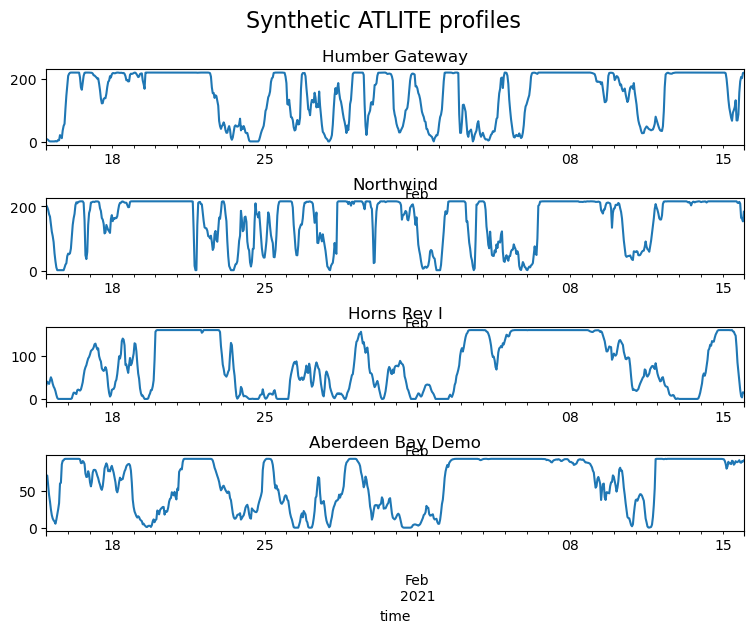

In [26]:
#fig, (ax1,ax2,ax3) =plt.subplots(3,1) #warum fehlen die Timestamps als Label?
#       #fig.set_title("ATLITE Generation profiles")
#    h['Hornsea 1'].plot(ax=ax1)
#    h['Horns Rev 2'].plot(ax=ax2)
#    h['Rentel'].plot(ax=ax3)



#names must macht the ones form the sites-dataframe

fig, (ax1,ax2,ax3,ax4) =plt.subplots(4,1,figsize=(9,6)) #warum fehlen die Timestamps als Label?
fig.suptitle('Synthetic ATLITE profiles', fontsize=16)
h1['Humber Gateway Wind Farm'].plot(ax=ax1, title= 'Humber Gateway')
h1['Northwind'].plot(ax=ax2, title= 'Northwind')
# Horns rev 1 has a different set of turbines
h2['Horns Rev I'].plot(ax=ax3,title='Horns Rev I')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)


h3['Aberdeen Bay Demo'].plot(ax=ax4,title='Aberdeen Bay Demo')




**Plotting Horns Rev A. Northwind and Humber Gateway**

Strange: i only plotted HOWOA-2, because data is only available for that part
there are Hornsea1,2,3
Hornsea:
One: 1.218 MW
Two: 1.386 MW
Three: 2.852 MW
bis zu 6.000 MW (ganzes Potentialgebiet)
Eigentümer 	Ørsted
Gründung 	Monopiles[1][2]
Turbine 	One: 174 × Siemens Gamesa SWT-7.0-154
Two: 165 × SG 8.0-167 DD 

Lösung: Became fully operational on 31 August 2022
also wird es vorher geringere kapzität gehabt haben

war die faktische Einspeisung gering, weil der Park noch klein war? 

Text(0.5, 0.98, 'ATLITE blue vs ENTSOE red, mid of Jan 21')

<AxesSubplot:title={'center':'Humber Gateway'}, xlabel='time'>

<AxesSubplot:title={'center':'Humber Gateway'}, xlabel='TimeIndex'>

(0.0, 262.8)

<AxesSubplot:title={'center':'Northwind'}, xlabel='time'>

<AxesSubplot:title={'center':'Northwind'}, xlabel='TimeIndex'>

(0.0, 259.2)

<AxesSubplot:title={'center':'Horns Rev I'}, xlabel='time'>

<AxesSubplot:title={'center':'Horns Rev I'}, xlabel='TimeIndex'>

(0.0, 192.0)

<AxesSubplot:title={'center':'Aberdeen Bay Demo'}, xlabel='time'>

<AxesSubplot:title={'center':'Aberdeen Bay Demo'}, xlabel='TimeIndex'>

(0.0, 111.84)

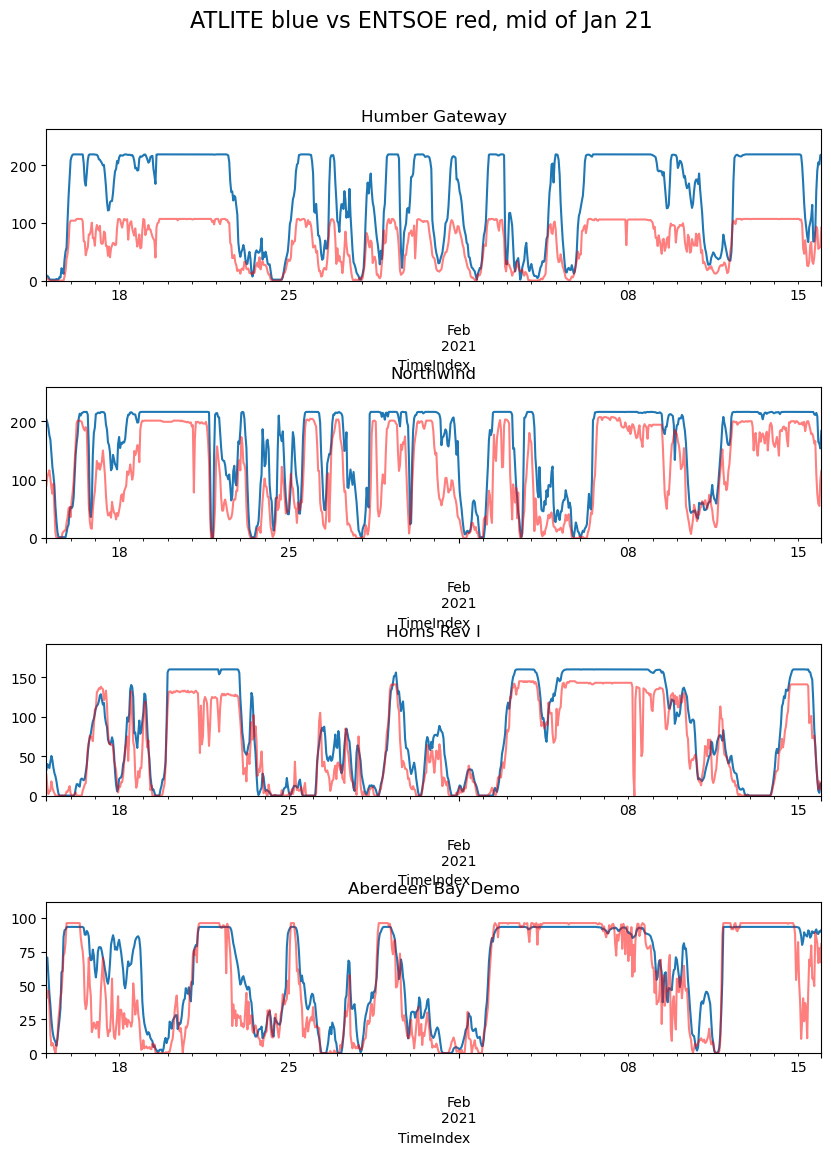

In [27]:

#fig, (ax1,ax2,ax3) =plt.subplots(3,1) #warum fehlen die Timestamps als Label?
#farms_gb['HOWAO-2'].plot(ax=ax1,color='red')
#h['Hornsea 1'].plot(ax=ax1)
#farms_dk['Horns Rev B'].plot(ax=ax2)
#h['Horns Rev 2'].plot(ax=ax2)
#farms_be['Rentel Offshore WP'].plot(ax=ax3)
#h['Rentel'].plot(ax=ax3)

fig, (ax1,ax2,ax3,ax4) =plt.subplots(4,1, figsize=(10,12)) #warum fehlen die Timestamps als Label?
fig.suptitle('ATLITE blue vs ENTSOE red, mid of Jan 21', fontsize=16)

h1['Humber Gateway Wind Farm'].plot(ax=ax1, title= 'Humber Gateway')
farms_gb['HMGTO-1'].plot(ax=ax1,color='red',alpha=0.5)
ax1.set_ylim(0,h1['Humber Gateway Wind Farm'].max()*1.2)

h1['Northwind'].plot(ax=ax2, title= 'Northwind')
farms_be['Northwind'].plot(ax=ax2,color='red',alpha=0.5)
ax2.set_ylim(0,h1['Northwind'].max()*1.2)

# Horns rev 1 has a different set of turbines
h2['Horns Rev I'].plot(ax=ax3,title='Horns Rev I')
farms_dk['Horns Rev A'].plot(ax=ax3,color='red',alpha=0.5)
ax3.set_ylim(0,h2['Horns Rev I'].max()*1.2)


h3['Aberdeen Bay Demo'].plot(ax=ax4,title='Aberdeen Bay Demo')
farms_gb['ABRBO-1'].plot(ax=ax4,color='red',alpha=0.5)
ax4.set_ylim(0,h3['Aberdeen Bay Demo'].max()*1.2)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)

#new set
#ENTSOE name
#HMGTO-1
#Horns Rev A
#Northwind
#
#shapefile name
#
#Humber Gateway Wind Farm
#Horns Rev I
#Northwind
#
#

Text(0.5, 0.98, 'Deviations between ATLITE and ENTSOE real world data')

<AxesSubplot:title={'center':'Humber Gateway'}, xlabel='time'>

<AxesSubplot:title={'center':'Northwind'}, xlabel='time'>

<AxesSubplot:title={'center':'Horns Rev I'}, xlabel='time'>

<AxesSubplot:title={'center':'Aberdeen Bay Demo'}, xlabel='time'>

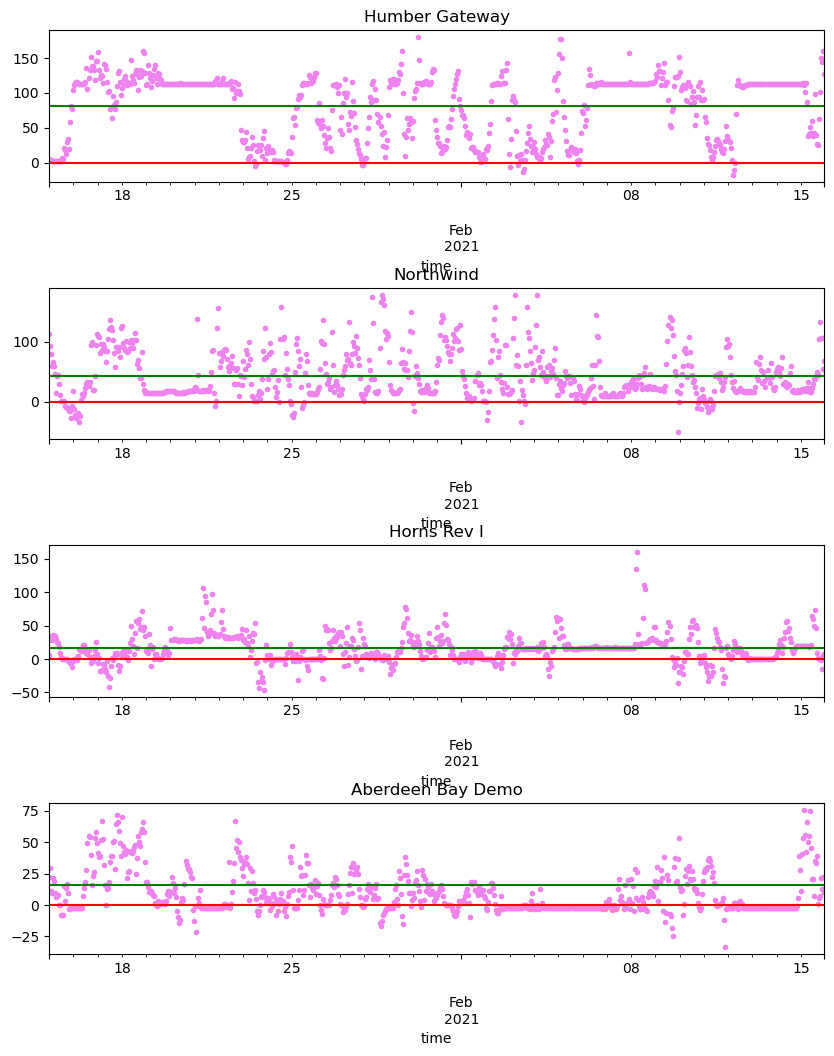

In [28]:
pd.reset_option('display.max_rows')


fig.suptitle('Deviations between ATLITE and ENTSOE real world data', fontsize=16)

fig, (ax1,ax2,ax3,ax4) =plt.subplots(4,1, figsize=(10,12))


#a time-zone naive df cannot be matche with a tz-Timeindex--> localize
#then: subtract
diff1 = h1['Humber Gateway Wind Farm'].tz_localize('utc').subtract(farms_gb['HMGTO-1'])

diff1.plot(ax=ax1, title= 'Humber Gateway',color='violet',style='.')
ax1.axhline(y = 0, color = 'r', linestyle = '-')
mean1= diff1.mean()
ax1.axhline(y = mean1 , color = 'g', linestyle = '-')



diff2 = h1['Northwind'].tz_localize('utc').subtract(farms_be['Northwind'])

diff2.plot(ax=ax2, title= 'Northwind',color='violet',style='.')
ax2.axhline(y = 0, color = 'r', linestyle = '-')
mean2= diff2.mean()
ax2.axhline(y = mean2 , color = 'g', linestyle = '-')



diff3 = h2['Horns Rev I'].tz_localize('utc').subtract(farms_dk['Horns Rev A'])

diff3.plot(ax=ax3, title= 'Horns Rev I',color='violet',style='.')
ax3.axhline(y = 0, color = 'r', linestyle = '-')
mean3= diff3.mean()
ax3.axhline(y = mean3 , color = 'g', linestyle = '-')

diff4 = h3['Aberdeen Bay Demo'].tz_localize('utc').subtract(farms_gb['ABRBO-1'])

diff4.plot(ax=ax4, title= 'Aberdeen Bay Demo',color='violet',style='.')
ax4.axhline(y = 0, color = 'r', linestyle = '-')
mean4= diff4.mean()
ax4.axhline(y = mean3 , color = 'g', linestyle = '-')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)



**Getting ATLITE wind data from the cutout** <br>
analogously to HiWind wind speed comparison.ipynb

In [29]:
#humber.centroid
#northwind.centroid
#hornsrev1.centroid
#aberdeen.centroid
#

#ein Dataframe mit denselben Daatetime-Index wie die ENTSOE/ATLITE Kurven
#als Einträge die WIndgeschwindigkeiten
windspeeds_humber= pd.DataFrame(index=farms_gb.index,columns=['windspeed'])
c1= cutout.data.sel({"x":humber.centroid.x.values,"y":humber.centroid.y.values},'nearest')
windspeeds_humber['windspeed']= c1.get('wnd100m').values.flatten()

windspeeds_northwind= pd.DataFrame(index=farms_be.index,columns=['windspeed'])
c2= cutout.data.sel({"x":northwind.centroid.x.values,"y":northwind.centroid.y.values},'nearest')
windspeeds_northwind['windspeed']= c2.get('wnd100m').values.flatten()

windspeeds_hornsrev1= pd.DataFrame(index=farms_dk.index,columns=['windspeed'])
c3= cutout.data.sel({"x":hornsrev1.centroid.x.values,"y":hornsrev1.centroid.y.values},'nearest')
windspeeds_hornsrev1['windspeed']= c3.get('wnd100m').values.flatten()

windspeeds_aberdeen= pd.DataFrame(index=farms_gb.index,columns=['windspeed'])
c4= cutout.data.sel({"x":aberdeen.centroid.x.values,"y":aberdeen.centroid.y.values},'nearest')
windspeeds_aberdeen['windspeed']= c4.get('wnd100m').values.flatten()


windspeeds_hornsrev1['windspeed']

TimeIndex
2021-01-15 00:00:00+00:00    6.831855
2021-01-15 01:00:00+00:00    7.311739
2021-01-15 02:00:00+00:00    7.150610
2021-01-15 03:00:00+00:00    7.005075
2021-01-15 04:00:00+00:00    7.439699
                               ...   
2021-02-15 19:00:00+00:00    5.889447
2021-02-15 20:00:00+00:00    4.156876
2021-02-15 21:00:00+00:00    3.697082
2021-02-15 22:00:00+00:00    5.323788
2021-02-15 23:00:00+00:00    5.264841
Name: windspeed, Length: 768, dtype: float32

Text(0.5, 0.98, 'Scatterplots that pair actual and projected generation for every timestamp ')

(TimeIndex
 2021-01-15 00:00:00+00:00     3.5
 2021-01-15 01:00:00+00:00     4.0
 2021-01-15 02:00:00+00:00     2.5
 2021-01-15 03:00:00+00:00     0.0
 2021-01-15 04:00:00+00:00     0.0
                              ... 
 2021-02-15 19:00:00+00:00    89.5
 2021-02-15 20:00:00+00:00    55.0
 2021-02-15 21:00:00+00:00    57.0
 2021-02-15 22:00:00+00:00    58.0
 2021-02-15 23:00:00+00:00    92.0
 Freq: H, Name: HMGTO-1, Length: 768, dtype: float64,
 time
 2021-01-15 00:00:00      8.679224
 2021-01-15 01:00:00      8.308458
 2021-01-15 02:00:00      6.215777
 2021-01-15 03:00:00      2.938327
 2021-01-15 04:00:00      1.638049
                           ...    
 2021-02-15 19:00:00    191.157670
 2021-02-15 20:00:00    205.034313
 2021-02-15 21:00:00    201.417455
 2021-02-15 22:00:00    217.521260
 2021-02-15 23:00:00    218.598008
 Name: Humber Gateway Wind Farm, Length: 768, dtype: float64,
 TimeIndex
 2021-01-15 00:00:00+00:00     3.934402
 2021-01-15 01:00:00+00:00     3.892418
 2021-

Text(0.5, 1.0, 'Humber Gateway')

(0.0, 219.0)

(0.0, 219.0)

Text(0.5, 0, 'ENTSOE values')

Text(0, 0.5, 'ATLITE values')

Text(0.5, 0, 'ENTSOE values')

Text(0, 0.5, 'ATLITE values')

Text(0.5, 0, 'ENTSOE values')

Text(0, 0.5, 'ATLITE values')

Text(0.5, 0, 'ENTSOE values')

Text(0, 0.5, 'ATLITE values')

Text(0.5, 1.0, 'Northwind')

(0.0, 216.0)

(0.0, 216.0)

Text(0.5, 1.0, 'Horns Rev')

(0.0, 160.0)

(0.0, 160.0)

Text(0.5, 1.0, 'Aberdeen Bay Demo')

(0.0, 93.2)

(0.0, 93.2)

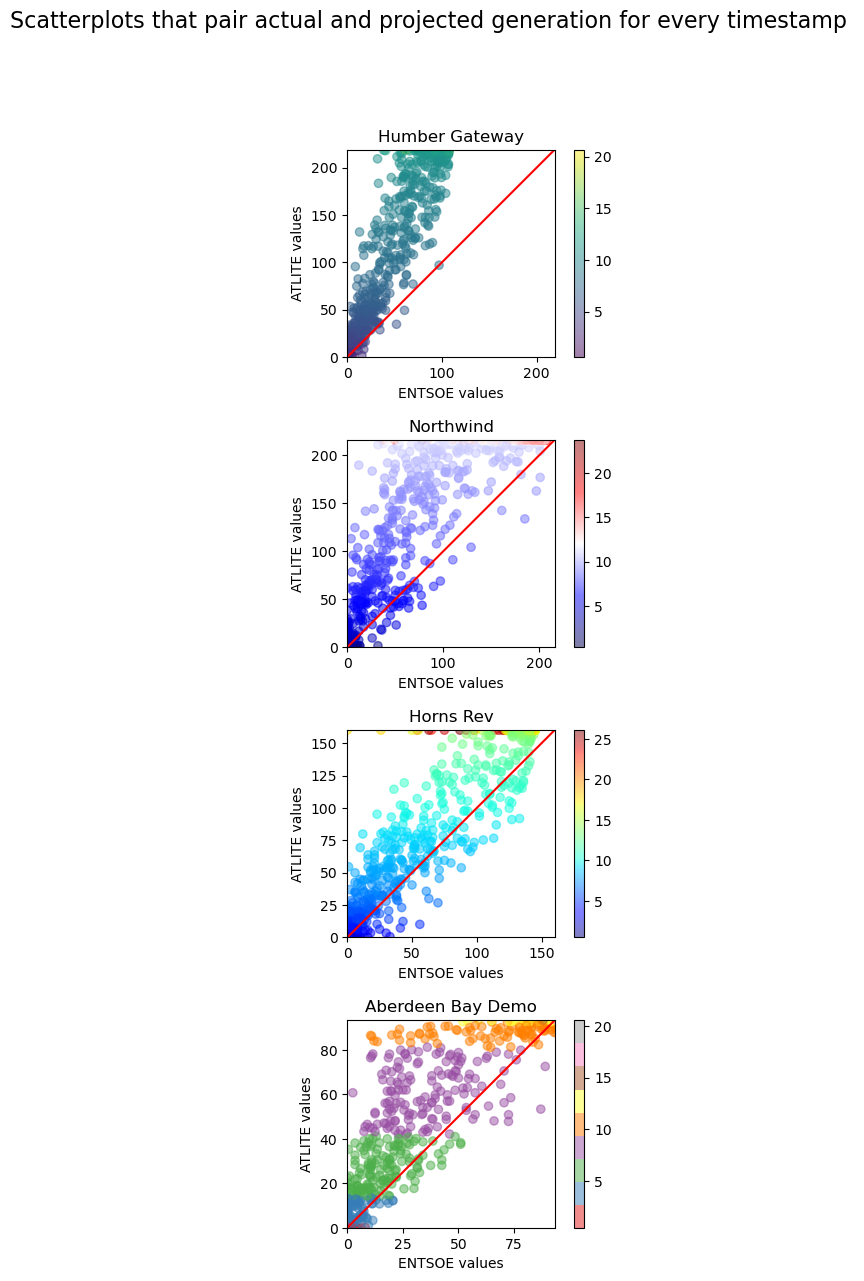

In [30]:

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


fig, (ax1,ax2,ax3,ax4) =plt.subplots(4,1, figsize=(5,14)) #warum fehlen die Timestamps als Label?
fig.suptitle('Scatterplots that pair actual and projected generation for every timestamp ', fontsize=16)

#the red line will always adjust to the box, thats why it will onyl be a bisecotr if we fi the plot delimitations

x1= farms_gb['HMGTO-1']
y1= h1['Humber Gateway Wind Farm']
z1= windspeeds_humber['windspeed']
x1,y1,z1
scat1=ax1.scatter(x1, y1,c=z1,cmap='viridis',alpha=0.5) #vmax wäre hier theoretisch anwendbar
ax1.set_title('Humber Gateway') 
ax1.set_xlim(0,y1.max())
ax1.set_ylim(0,y1.max())


for ax in fig.get_axes():
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line) 
    ax.set_xlabel('ENTSOE values')
    ax.set_ylabel('ATLITE values')
    ax.set_aspect('equal', 'box')

fig.colorbar(scat1,ax=ax1)
    

x2= farms_be['Northwind']
y2= h1['Northwind']
z2= windspeeds_northwind['windspeed']
scat2= ax2.scatter(x2, y2, c=z2, cmap='seismic',alpha=0.5)
ax2.set_title('Northwind')
ax2.set_xlim(0,y2.max()) #if we use set_aspect, this is not necessary
ax2.set_ylim(0,y2.max())

fig.colorbar(scat2,ax=ax2)



x3= farms_dk['Horns Rev A']
y3= h2['Horns Rev I']
z3= windspeeds_hornsrev1['windspeed']

scat3= ax3.scatter(x3, y3,c=z3, cmap='jet', alpha=0.5)

ax3.set_title('Horns Rev')
ax3.set_xlim(0,y3.max())
ax3.set_ylim(0,y3.max())
fig.colorbar(scat3,ax=ax3)


x4= farms_gb['ABRBO-1']
y4= h3['Aberdeen Bay Demo']
z4= windspeeds_aberdeen['windspeed']

scat4= ax4.scatter(x4, y4,c=z4, cmap='Set1', alpha=0.5)
ax4.set_title('Aberdeen Bay Demo')
ax4.set_xlim(0,y4.max())
ax4.set_ylim(0,y4.max())
fig.colorbar(scat4,ax=ax4)


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)



**Hier nochmal mit Seabron ähnliche Scatterplots machen**

In [31]:
#TODO
#sns.set(style='whitegrid')
#fmri = zip(x2,y2)
# 
#sns.scatterplot(x=x2,y=y2,data=fmri)

# Exclusion Zones

**Take coastlines from cartopy does not work**

**Take the Cutoutgrids coordinates from above and turn into a polygon
<br> afterwards overlay with Country Border Plots**
coast 0 : the countries' coasts merged <br>
coast 1 : reduced to the cutout <br>
coast 0 : a shapefile that is the negative thus constitues the north sea <br>

<AxesSubplot:>

<AxesSubplot:>

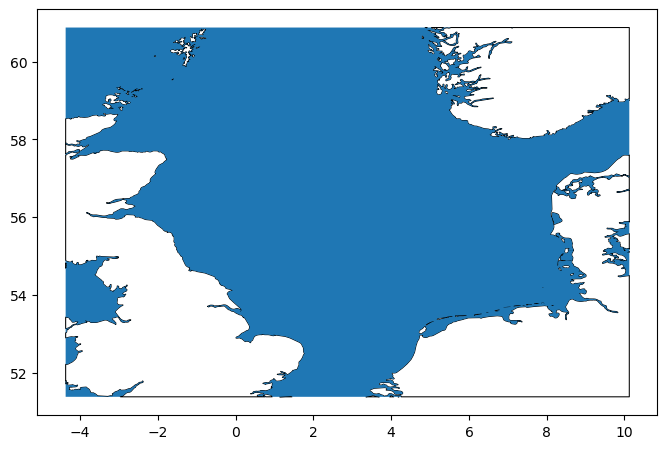

In [32]:
fig,ax = plt.subplots(figsize=(8,9))

coast0= gpd.GeoSeries([BorderingStates_init.unary_union]) #dissolve works only with GPDFs, unary_union returns a Multiploygon#coast0
coast1= coast0.clip(country_bound)

#plotting only the exterior
coast1.boundary.plot(ax=ax, zorder=1, linewidth=0.75,edgecolor='black')

coast2 = country_bound.difference(coast1) #creates a negative from a series, does not work on Dataframes: country_bound -coast1 is also allowed

#coast2= coast1.overlay(country_bound, how='difference') #works only on dataframes

coast2.plot(ax=ax)

#country_bound.plot(ax=ax,edgecolor='orange')
#coast= BorderingStates_init.dissolve(by='geometry')
#coast.plot(ax=ax)b

**Import GEBCO**<br>
From the documentation: The GEBCO grid can be assumed to be relative to WGS84.

List of colormaps:
https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
https://matplotlib.org/stable/tutorials/colors/colormaps.html

CRS.from_epsg(4326)

Affine(0.004166666666666669, 0.0, -5.612500000000013,
       0.0, -0.004166666666666668, 61.0)

BoundingBox(left=-5.612500000000013, bottom=50.75, right=10.599999999999996, top=61.0)

rasterio.io.DatasetReader

(2460, 3891)

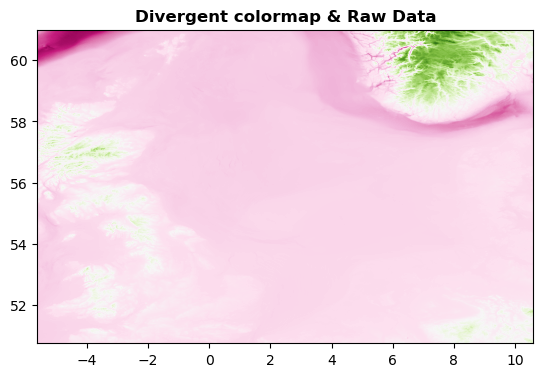

<AxesSubplot:title={'center':'Divergent colormap & Raw Data'}>

In [33]:
import rasterio
bathy = rasterio.open('..\data\GEBCO\gebco_2022_n61.0_s50.75_w-5.6143_e10.6.tif')
#man diarf diese Attribute nicht nach .read aufrufen
bathy.crs
bathy.transform
bathy.bounds
type(bathy) #RasterioDataSetReader
bathy_plot= bathy.read(1)
bathy.shape
#these are numerical values in contrast to integeres that represent categories in the examplte
#plt.imshow(bathy, cmap='tab20')
#Alt1:
from rasterio.plot import show
show(bathy_plot,transform=bathy.transform,cmap='PiYG',title="Divergent colormap & Raw Data")

#Alt 2
#plt.imshow(bathy_plot, cmap='PiYG')



<AxesSubplot:>

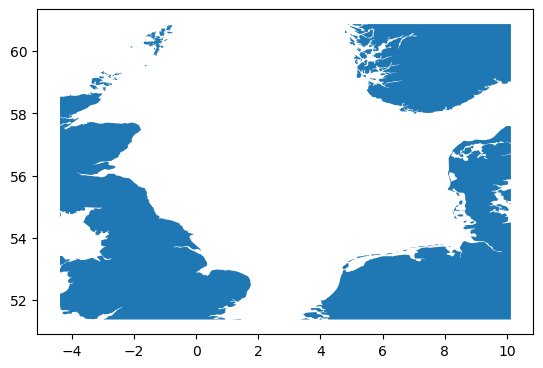

In [34]:
coast1.plot()


BoundingBox(left=-5.612500000000013, bottom=50.75, right=10.599999999999996, top=61.0)

array([-4.375, 51.375, 10.125, 60.875])

(-4.375, 10.125)

(51.375, 60.875)

<AxesSubplot:>

(-4.375, 10.125)

(51.375, 60.875)

<AxesSubplot:>

(-4.375, 10.125)

(51.375, 60.875)

<AxesSubplot:>

(-4.375, 10.125)

(51.375, 60.875)

<AxesSubplot:>

(-4.375, 10.125)

(51.375, 60.875)

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Sequential Colormap & Fixed Interval [-200;0]')

array([-100,  -60,  -50,  -40,  -30,  -20,   -5,    0])

Text(0.5, 1.0, 'Discrete, new Colormap & Fixed Interval [-100;0] & Proportional Colorbar\n')

Text(0.5, 1.0, 'Sequential, new Colormap from List & Fixed Interval [-80;0], adapted nodes, intervalls untouched \nObviously nodes and lower bound were tweaked to approximate figure above')

<AxesSubplot:>

Text(0.5, 1.0, 'Divergent colormap & Fixed Interval[-200;0]')

<AxesSubplot:>

Text(0.5, 1.0, 'Sequential colormap & Intervalls Changed by TwoSlopeNorm ')

['−200', '−175', '−150', '−125', '−100', '−75', '−50', '−25', '0']

[Text(1, -200.0, '≤−200'),
 Text(1, -175.0, '−175'),
 Text(1, -150.0, '−150'),
 Text(1, -125.0, '−125'),
 Text(1, -100.0, '−100'),
 Text(1, -75.0, '−75'),
 Text(1, -50.0, '−50'),
 Text(1, -25.0, '−25'),
 Text(1, 0.0, '≥0')]

['−1200', '−1000', '−800', '−600', '−400', '−200', '0']

[Text(1, -1200.0, '≤−1200'),
 Text(1, -1000.0, '−1000'),
 Text(1, -800.0, '−800'),
 Text(1, -600.0, '−600'),
 Text(1, -400.0, '−400'),
 Text(1, -200.0, '−200'),
 Text(1, 0.0, '≥0')]

['−100', '−60', '−50', '−40', '−30', '−20', '−5', '0']

[Text(1, -100, '≤−100'),
 Text(1, -60, '−60'),
 Text(1, -50, '−50'),
 Text(1, -40, '−40'),
 Text(1, -30, '−30'),
 Text(1, -20, '−20'),
 Text(1, -5, '−5'),
 Text(1, 0, '≥0')]

['−80', '−70', '−60', '−50', '−40', '−30', '−20', '−10', '0']

[Text(1, -80.0, '≤−80'),
 Text(1, -70.0, '−70'),
 Text(1, -60.0, '−60'),
 Text(1, -50.0, '−50'),
 Text(1, -40.0, '−40'),
 Text(1, -30.0, '−30'),
 Text(1, -20.0, '−20'),
 Text(1, -10.0, '−10'),
 Text(1, 0.0, '≥0')]

['−200', '−175', '−150', '−125', '−100', '−75', '−50', '−25', '0']

[Text(1, -200.0, '≤−200'),
 Text(1, -175.0, '−175'),
 Text(1, -150.0, '−150'),
 Text(1, -125.0, '−125'),
 Text(1, -100.0, '−100'),
 Text(1, -75.0, '−75'),
 Text(1, -50.0, '−50'),
 Text(1, -25.0, '−25'),
 Text(1, 0.0, '≥0')]

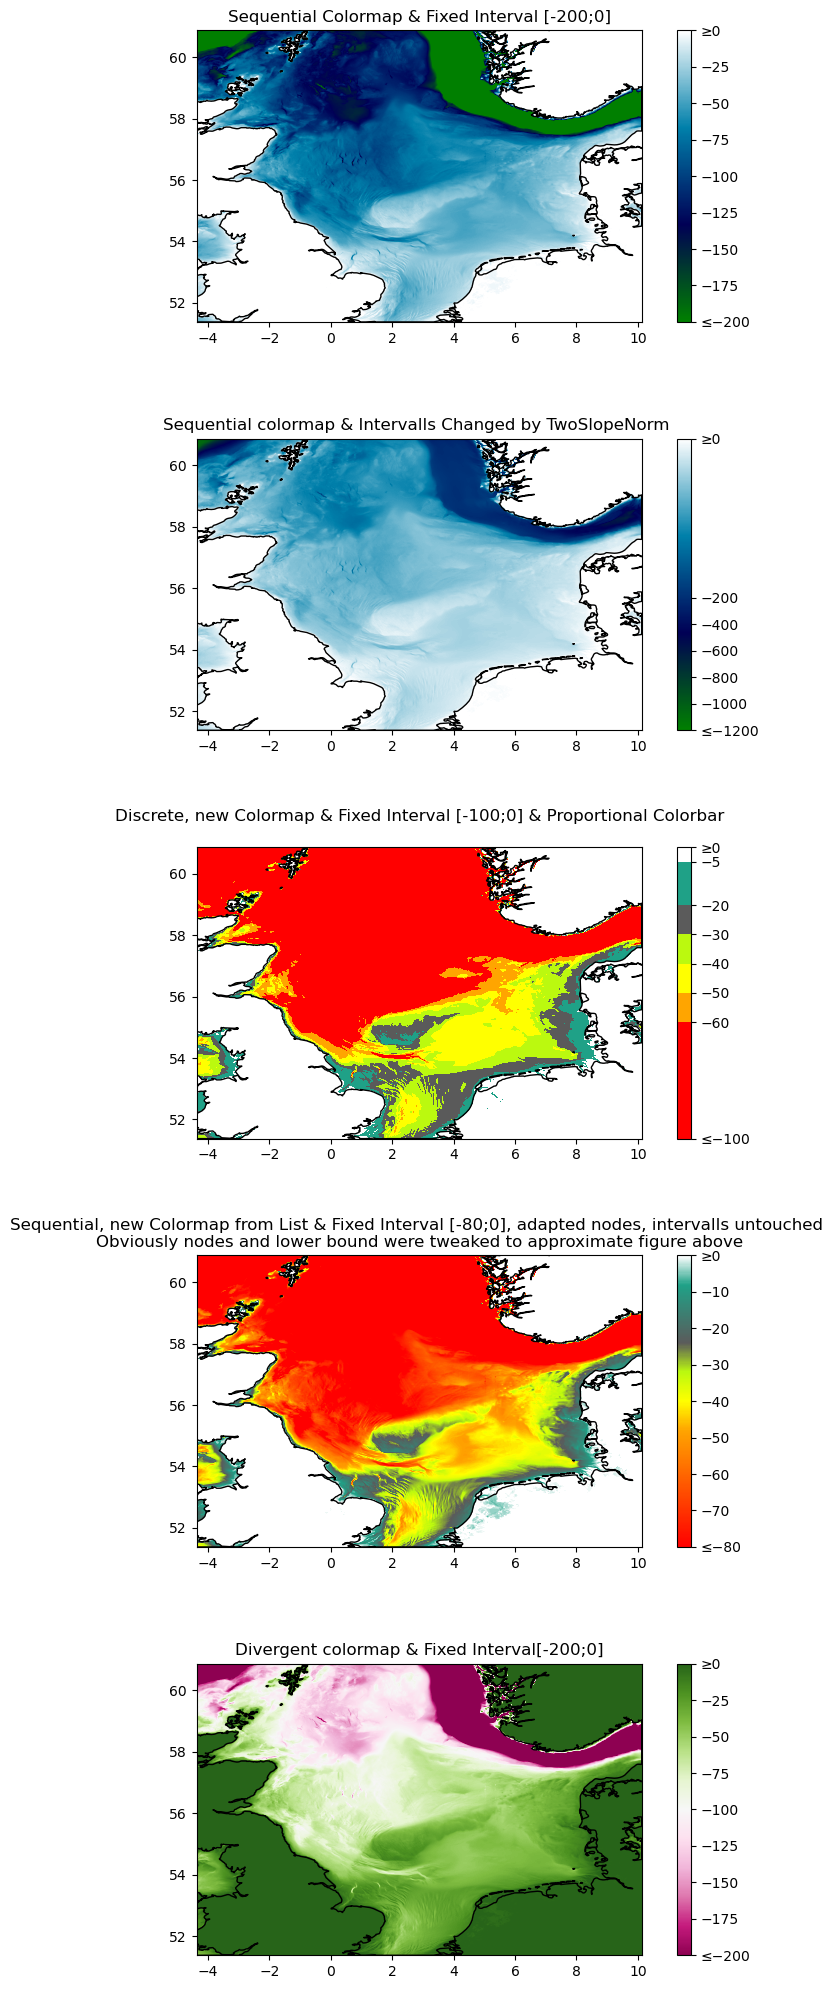

In [35]:
import matplotlib.colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

gebco = rasterio.open('..\data\GEBCO\gebco_2022_n61.0_s50.75_w-5.6143_e10.6.nc')

#die Reihenfolge der Achsen-Elemente bestimmt die Plot-Reihenfolge
fig, (ax,ax5,ax1,ax3,ax2) = plt.subplots(5,figsize=(9,25))
gebco1= gebco.read(1)

# gebco1= np.where(gebco1 < 0,gebco1, 0) #alle Daten drängen sich im Bereich von 0 bis -200 --> fast alles farblich einheitlich
#verändere Farbschema 

#das .tif ist etwas größer, deswegen Zuschnitt
gebco.bounds
coast2.total_bounds
xmin,ymin,xmax,ymax =coast2.total_bounds
for axis in fig.get_axes():
    axis.set_xlim(xmin,xmax)
    axis.set_ylim(ymin,ymax)
    coast2.plot(ax=axis, color='none')
    #ax.set_xlim(xmin+6.5,xmax-1) #zoom into German Bight
    #ax.set_ylim(ymin+1,ymax-2)

#workaround: normally: rasterio.plt.show does not show the colorbar, use ax.imshow as surrogate
#assign it to variable image_hidden, so that colorbar can be linked to it

#das wäre ein matplotlib eigene Farbpalette für Unterwasser, dafür cmaß= 'ocean' durch cmaß = undersea eretzen
#nicht so beeindruckend
#colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
#undersea = mpl.colors.LinearSegmentedColormap.from_list(
#    'undersea', colors_undersea) #der Name bringt nur was, wenn man die colormap registered
#


image_hidden= ax.imshow(gebco1, cmap='ocean', vmin=-200,vmax=0)
fig.colorbar(image_hidden,ax=ax)
image_hidden.set_visible(False)
rasterio.plot.show(gebco1,transform=gebco.transform, ax=ax,cmap='ocean', vmin=-200,vmax=0)
ax.set_title("Sequential Colormap & Fixed Interval [-200;0]")


#Variante 2:
#Different objects are returned by plt.imshow() and rasterio.plot.show(). plt.colorbar() is expecting a mappable object so it gets confused. Because rasterio plotting is a wrapper over matplotlib
#I think the most straightforward approach is to provide the underlying object maptlotlib is expecting


#create an irregular colormap interval in order to resolve the interesting area -500 to 0 m highly resoluted
#a= np.append(np.array(np.linspace(-1200,-200,1)), np.array(np.linspace(-200,0,4)))
#a = np.array(np.linspace(-100,0,5))
#make Doggerbank more visible
a = np.array([-100,-60,-50,-40,-30,-20,-5,0])
a
#mit ListedColormap kann man zum einen bekannte Colormaps für die weitere Verwendung bereitstellen
#zum anderen seine eigene neue Liste definieren
#die Werte werden von links genommen, überzählige werden nicht verwendet
mycmap = matplotlib.colors.ListedColormap(['red','orange','yellow',
                                           '#BBF90F','0.35621',[0.122312, 0.633153, 0.530398, 1.0],'white'])


#für boundary norm legt man eine diskrete menge an Intervallen und farben fest, vermutlich ist sequential colormap wie bone ungeeignet
#ncolors muss -1 sein, weil ja die Farben ZWISCHEN den Intervallgrenzen liegen
image= show(gebco1,transform=gebco.transform, ax=ax1,cmap=mycmap,norm=mpl.colors.BoundaryNorm(boundaries=a, ncolors=len(a)-1))
im = image.get_images()[0]
fig.colorbar(im, ax=ax1,spacing='proportional')

ax1.set_title("Discrete, new Colormap & Fixed Interval [-100;0] & Proportional Colorbar\n")





#Variante 2b als qequential map from list, nutzt auch die Intervalle von a und dieselben Farben, aber als Liste
#Ziel: ich will die interpolierten Übergänge sehen
#boundary norm funktionier bei einer sequential map nicht 
#Eingabe ist eine Liste, ein colormap-Objekt alleine geht nicht
origin_list=['red','orange','yellow','#BBF90F','0.35621',[0.122312, 0.633153, 0.530398, 1.0],'white']

#aber Vorsicht, die nodes Werte sind die prozentuel Länge am Colormap-Balken, man beeinflusst damit nicht die Intervalle
#man muss ein bisschen rumspielen und zugleich beachten, dass es 7 Werte sind,damit zwischen 7 Farben sequenziert werden kann
nodes= [0,0.4,0.5,0.6,0.7,0.90,1]
cmap1 = LinearSegmentedColormap.from_list("mycmap1",list(zip(nodes,origin_list)))
#diese Helper-Funktion erzeugt eine diskrete Colorbar und die Norm dazu in einem Zug, Ergebnis ist dasselbe wie oben bei cmap
#levels= [-300,-150,-75,-60,-30,0,25]
#cmap1,norm_from_level = mpl.colors.from_levels_and_colors(levels,origin_list[:-1])
#image= show(gebco1,transform=gebco.transform, ax=ax3,cmap=cmap1,norm=norm_from_level)

#wenn ich auf die nodes verzichte, krieg ich dasselbe wie eine vorinstallierte sequential map, siehe oben bei 'ocean'
#ich setze die nodes, damit ich meine diskreten Grenzen auch hier wiederfinde
image= show(gebco1,transform=gebco.transform, ax=ax3,cmap=cmap1,vmin=-80,vmax=0)
im = image.get_images()[0]
fig.colorbar(im, ax=ax3)
ax3.set_title("Sequential, new Colormap from List & Fixed Interval [-80;0], adapted nodes, intervalls untouched \n\
Obviously nodes and lower bound were tweaked to approximate figure above")

#nachteilig: alle Werte drängen sich, weil ich keinen Einfluss habe auf die Abstände der Werte
#sondern nur grob proenztual die Farbwerte beeinfluss kann
#deswegen nehm ich geringeres vmin


#Variante 3 des rasterio-Plotting:
image2 = ax2.imshow(gebco.read()[0],cmap='PiYG',vmin=-200,vmax=0)
fig.colorbar(image2, ax=ax2)

#image2.colorbar.ax oder fig.colorbar(image2, ax=ax2).ax enthalten die ticks-Werte
#ticks = fig.colorbar(image2, ax=ax2).ax.get_yticks() #gibt die Zahlenwerte aus, wo ticks sind

rasterio.plot.show(gebco1,transform=gebco.transform, ax=ax2,cmap='PiYG',vmin=-200,vmax=0)
ax2.set_title("Divergent colormap & Fixed Interval[-200;0]")




#ocean mit TwoSlope Norm
image2 = ax5.imshow(gebco.read()[0],cmap='ocean',norm=mpl.colors.TwoSlopeNorm(vmin=-1200,vcenter=-100,vmax=0))
fig.colorbar(image2, ax=ax5)
rasterio.plot.show(gebco1,transform=gebco.transform, ax=ax5,cmap='ocean',norm=mpl.colors.TwoSlopeNorm(vmin=-1200,vcenter=-200,vmax=0))
ax5.set_title("Sequential colormap & Intervalls Changed by TwoSlopeNorm ")



#editing the top and bottom label in every figure 
#analogously to get_axes()
def get_colorbars(fig): #taken from https://stackoverflow.com/questions/53870706/retrieve-all-colorbars-in-figure
    cbs = []
    for ax in fig.axes:
        cbs.extend(ax.findobj(lambda obj: hasattr(obj, "colorbar") and obj.colorbar))
    return [a.colorbar for a in cbs]

for cbar in get_colorbars(fig):
    plt.draw()
    b= [l.get_text() for l in cbar.ax.get_yticklabels()]
    b
    b[0]= "≤"+b[0]
    b[-1]= "≥" + b[-1]
    cbar.ax.set_yticklabels(b)
    

    
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    

Statt der >_ und <_ könnte mauch die with over extremes benutzen 
https://matplotlib.org/stable/tutorials/colors/colorbar_only.html#colorbar-with-custom-extension-lengths

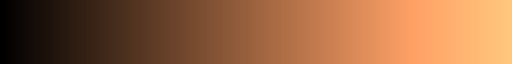

In [36]:
plt.cm.copper

In [37]:
# make noise in 1% of the image pixels
x = np.linspace(0, 10, 1000)
I = np.sin(x) * np.cos(x[:, np.newaxis])
speckles = (np.random.random(I.shape) < 0.01)
I[speckles] = np.random.normal(0, 3, np.count_nonzero(speckles))
I[speckles]

array([-2.20728919, -1.08461858, -0.22397659, ...,  0.05528179,
       -1.52356772, -0.69759934])

opted in first image to exclude the data above 0 and below -200
histogram hints that the interesting parts are below 200
much more differentiated in that area. The histogram depicts the distribution of the datapoints with a clear concentration in said area. Excluding values above 0 means discarding the for our analysis unnecessary onshore elevation. Likewise, values below -200 distort the depiction toward the relatively deep Norwegian trench. The 
-1200 would mean only very minor differentiation in the color grading for the entirety of the North Sea.

another look at it: discerete intervals that are delimited by technological border:
60 m because of monopiles
200 m beacuse of....
a clearer view which is more helpful when analysing potential areas
Loss of differentation is traded in for the sake of clear distinction between zones

but yet one has to keep in mind that there are portions of land below sea level within countries mainland, e.g. the Ijsselmeer in the Netherlands
that is why shapefiles are crucial to the extents of potential sites

TODO: eigentlich müsste man den Colorbar mit einem <200 und <-1200 versehen.


shallow water restriction from Gebco

Plot 2 hat diskrete Grenzen, die ich gesetzt hate, spacing = proportional passt auch den colorbar an
die Farben hab ich ausgewählt, eigentlicht beliebig brauch ich aber für diskrete Grenzen
Qualitative Colormaps sind auch sequential und könnten sowas nachahmen...
ohen spacing = proportional gibt es 7 gleich große flächen in der colorbar

Plot 3: eine selbstgebaute Sequential colormap from list hat erst mal keinen Vorteil, ohne nodes macht sie dasselbe wie Plot 1 nur in anderen Farben
mit nodes muss ich mühsam rumprobieren bis es inetwa passt
Intervalle bleiben unberührt,diese werden proportional gesetzt
Lösung sind arbitrary funcs
Plot 4: Intervalle per arbitraty funcs neu gesetzt

In [38]:
gebco.meta # important data on the raster data file
gebco2= gebco.read()
gebco2.shape
x, y = gebco.xy(15, 20) # Pixel in Koordinaten übersetzen
i, j = gebco.index(-1.5532, 55.000) # Koordinaten in Pixel umwandeln
gebco1[552,2200] # Pixelanwahl
gebco.bounds
coast2.total_bounds


{'driver': 'netCDF',
 'dtype': 'int16',
 'nodata': -32767.0,
 'width': 3891,
 'height': 2460,
 'count': 1,
 'crs': None,
 'transform': Affine(0.004166666666666669, 0.0, -5.612500000000013,
        0.0, -0.004166666666666668, 61.0)}

(1, 2460, 3891)

-130

BoundingBox(left=-5.612500000000013, bottom=50.75, right=10.599999999999996, top=61.0)

array([-4.375, 51.375, 10.125, 60.875])

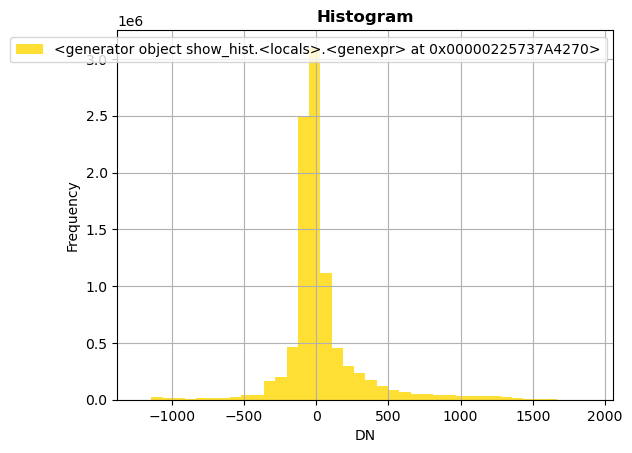

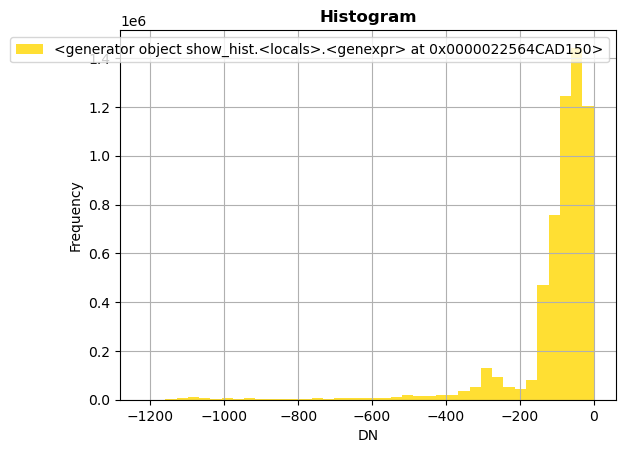

In [39]:
import numpy.ma as ma
u=rasterio.plot.show_hist(gebco1, bins=40, lw=0.0, stacked=False, alpha=0.8,
    histtype='stepfilled', title="Histogram")
rasterio.plot.show_hist(ma.masked_where(gebco1 > 0, gebco1), bins=40, lw=0.0, stacked=False, alpha=0.8,
    histtype='stepfilled', title="Histogram")


**Saving different limits as an nd.array**

In [40]:

import numpy.ma as ma


#vb=np.where( bathy_plot < 200)
#z= (bathy_plot < 0) | (bathy_plot > 200)

anti_cmap = matplotlib.colors.ListedColormap(["darkseagreen"])
#a is taken from above: numpy.array with set limit
depths_list= a.tolist() 
for d,i in enumerate(depths_list):
    d,i
    depths_list[d]= ma.masked_where((gebco1 > i) , gebco1)
    #coast2.plot(color='None')
    #show(depths_list[d],transform=bathy.transform,cmap=anti_cmap,title="Progressively shallower sea depths")
    

(0, -100)

(1, -60)

(2, -50)

(3, -40)

(4, -30)

(5, -20)

(6, -5)

(7, 0)

Reading in NATURA 2000

In [41]:
#%%timeit -n 1 -r 1 #somehhow, timeits prevents the file from being completely read in
#takes 18 to 23 seconds
natura2000= gpd.read_file(r"..\data\Natura2000\Natura2000_end2021_rev1_epsg3035.shp")
natura2000.crs
#the ETRS89 has its own CRS which does not use lat and lon 0-90 and 0-180

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

In [42]:
n2000=natura2000.copy()

In [43]:
BorderingStates_init = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['United Kingdom', 'Denmark','Germany','Norway','France','Netherlands','Belgium']) 

cells = cutout.grid
projection = ccrs.Orthographic( -5,30)
country_bound = gpd.GeoSeries(cells.unary_union)

helper = gpd.GeoDataFrame(geometry=BorderingStates_init.geometry).reset_index().rename(columns={'index':'Countries'})#so kommt man zu Index
helper= helper.clip(poly_gdf2)
inland= helper.dissolve() #dissolve works only with GPDFs, unary_union returns a Multiploygon#coast0
inland1= inland.clip(country_bound)
 #clip works with geoseries as expected
#is the same as coast1 from above, but as a gpdf
coast3= gpd.GeoDataFrame(["All countries"], geometry=coast2.geometry, crs=4326)
area1= gpd.GeoDataFrame(["Delimiter"], geometry=[polygon2], crs=4326)
coast3 = coast3.to_crs(3035)
area1=area1.to_crs(3035)
inland1=inland1.to_crs(3035)

coast2=coast2.set_crs(4326)
coast2=coast2.to_crs(3035)

#ist zu klein.... dänsiche Ostsee hat überreste, Elbe mitten drin
poly_gdf_excl_east= poly_gdf_excl_east.to_crs(3035)



In [44]:
#poly_gdf3=poly_gdf2.to_crs(3035)
#poly_gdf3
#n2000= natura2000.clip(poly_gdf3)
#poly_gdf3 = gpd.GeoDataFrame([1], geometry=[polygon2], crs=n2000.crs)


In [45]:
# we want to minimize the  get rid of shapefiles within countries and not within the cutout
#original data is very large
n2000= n2000.clip(area1).overlay(coast3,how='intersection').overlay(poly_gdf_excl_east,how='difference')
#n2000= n2000.clip(area1).overlay(inland1, how='difference')

In [46]:
n2000

SITECODE  \
0    DK00FX112   
1    SE0520189   
2    DK00EX024   
3    DK00EY134   
4    DK00DX319   
..         ...   
157  NL2008002   
158  NL2008001   
159  DE1003301   
160  BEMNZ0001   
161  BEMNZ0004   

                                                                        SITENAME  \
0                                                       Skagens Gren og Skagerak   
1                                                                        Bratten   
2                                                Hjarbæk Fjord og Simested Fjord   
3    Lovns Bredning, Hjarbæk Fjord og Skals, Simested og Nørre Ådal, Skravad Bæk   
4                                                                 Kastbjerg Ådal   
..                                                                           ...   
157                                                                   Klaverbank   
158                                                                  Doggersbank   
159                                                                   Doggerbank   
160                                                               Vlaamse Banken   
161                                                                SBZ 3 / ZPS 3   

     RELEASE_DA  MS SITETYPE          INSPIRE_ID              0  \
0    2018-02-02  DK        B      Dk.nst.ps.SAC1  All countries   
1    2021-10-04  SE        B  SE.SWEPA.SE0520189  All countries   
2    2018-02-02  DK        A     Dk.nst.ps.SPA24  All countries   
3    2018-02-02  DK        B     Dk.nst.ps.SAC30  All countries   
4    2018-02-02  DK        B    Dk.nst.ps.SAC223  All countries   
..          ...  ..      ...                 ...            ...   
157  2021-12-09  NL        B                None  All countries   
158  2021-12-09  NL        B                None  All countries   
159  2019-12-13  DE        B                None  All countries   
160  2021-12-14  BE        B                None  All countries   
161  2021-12-14  BE        A                   -  All countries   

                                                                                                                                                  geometry  
0    POLYGON ((4320593.965 3832468.028, 4320565.216 3832545.510, 4320524.048 3832617.232, 4320471.582 3832681.237, 4320042.443 3833052.372, 4319969.779...  
1                  POLYGON ((4328306.856 3929962.891, 4328326.392 3919304.299, 4328348.362 3907287.928, 4322680.391 3907259.966, 4328306.856 3929962.891))  
2    MULTIPOLYGON (((4275596.830 3721396.320, 4275635.426 3721395.166, 4275694.966 3721422.842, 4275734.268 3721446.025, 4275765.950 3721465.346, 42757...  
3    MULTIPOLYGON (((4279945.209 3715237.138, 4279908.528 3715240.305, 4279863.220 3715221.917, 4279868.706 3715215.312, 4279809.367 3715228.723, 42797...  
4    POLYGON ((4327222.714 3731184.304, 4327287.576 3731183.246, 4327318.133 3731233.274, 4327325.173 3731264.090, 4327327.813 3731331.635, 4327359.889...  
..                                                                                                                                                     ...  
157  POLYGON ((3869390.182 3437303.598, 3863561.863 3437958.178, 3854492.488 3438992.714, 3853380.650 3454237.265, 3852911.344 3464617.834, 3852295.038...  
158  POLYGON ((3862979.204 3524140.643, 3868402.250 3540393.758, 3879870.246 3573981.273, 3891221.114 3606608.922, 3894864.753 3617336.841, 3920665.316...  
159  POLYGON ((3920650.469 3633295.226, 3946195.631 3649521.430, 3960267.883 3644175.366, 3985691.289 3605115.039, 3957274.570 3598945.373, 3920650.469...  
160  POLYGON ((3786368.255 3177302.906, 3798250.487 3184432.106, 3806423.052 3178441.157, 3816316.995 3165587.006, 3808481.998 3166368.156, 3791180.297...  
161  POLYGON ((3846664.419 3165157.113, 3851892.635 3162526.263, 3852047.397 3162145.062, 3843105.997 3162976.191, 3841741.131 3163107.535, 3846664.419...  

[162 rows x 8 columns]

In [47]:
windfarm_new

OBJECTID         COUNTRY              NAME  N_TURBINES  POWER_MW  \
0           8         Belgium            Rentel          42    309.00   
1           9         Belgium           Norther          44    370.00   
2          10         Belgium           Seastar          30    252.00   
3          11         Belgium           Mermaid          28    235.20   
4          12         Belgium  C-Power (Zone A)          24    141.15   
..        ...             ...               ...         ...       ...   
199       300  United Kingdom               NE8           0      0.00   
200       301  United Kingdom               NE3           0      0.00   
201       302  United Kingdom               NE2           0      0.00   
202       305  United Kingdom                N1           0      0.00   
203       306  United Kingdom               NE1           0      0.00   

         STATUS  YEAR    COAST_DIST    AREA_SQKM NOTES  Shape_Leng  \
0    Production  2018  28354.728982    23.264154  None    0.260649   
1    Production  2018  19797.758680    38.445331  None    0.352805   
2    Production  2020  36085.954019    18.426179  None    0.222749   
3    Production  2020  48314.549431    16.676150  None    0.208196   
4    Production  2013  24793.536916    10.682070  None    0.174694   
..          ...   ...           ...          ...   ...         ...   
199     Planned  2020  74888.692695   338.514189  None    0.973250   
200     Planned  2020  36890.748999   264.507016  None    0.817893   
201     Planned  2020  11200.924116   345.204221  None    1.373264   
202     Planned  2020   3171.943583  1162.426770  None    1.817623   
203     Planned  2021  22486.088072   751.092432  None    1.793374   

     Shape_Area  0  \
0      0.003017  1   
1      0.004979  1   
2      0.002392  1   
3      0.002169  1   
4      0.001384  1   
..          ... ..   
199    0.051993  1   
200    0.040742  1   
201    0.053699  1   
202    0.181169  1   
203    0.121891  1   

                                                                                                                                                  geometry  
0    POLYGON ((2.90552 51.59822, 2.91429 51.59965, 2.93139 51.60670, 2.93972 51.61086, 2.95537 51.61985, 3.00353 51.59084, 2.99282 51.58800, 2.98329 51...  
1    POLYGON ((2.97331 51.48950, 2.93681 51.51286, 2.94508 51.51529, 2.97299 51.52806, 2.97883 51.53398, 2.98698 51.53413, 2.99118 51.53645, 2.99906 51...  
2    POLYGON ((2.84370 51.60708, 2.83087 51.60788, 2.81428 51.61465, 2.81934 51.61971, 2.83984 51.63631, 2.85773 51.65052, 2.86800 51.65772, 2.87846 51...  
3    POLYGON ((2.78949 51.71814, 2.78900 51.71771, 2.78857 51.71722, 2.78790 51.71661, 2.78748 51.71613, 2.75580 51.71063, 2.75513 51.71045, 2.71777 51...  
4                                   POLYGON ((2.90836 51.55810, 2.96208 51.53428, 2.93766 51.52309, 2.92797 51.52018, 2.88360 51.54680, 2.90836 51.55810))  
..                                                                                                                                                     ...  
199  POLYGON ((-1.06465 58.54189, -1.06962 58.53376, -1.07459 58.52563, -1.07956 58.51751, -1.08452 58.50938, -1.08948 58.50125, -1.09444 58.49312, -1....  
200  POLYGON ((-2.03549 58.50178, -2.03485 58.49302, -2.03421 58.48427, -2.03358 58.47551, -2.03294 58.46676, -2.03230 58.45800, -2.03166 58.44925, -2....  
201  POLYGON ((-2.06710 58.93342, -2.08003 58.92768, -2.09296 58.92193, -2.10588 58.91618, -2.11880 58.91043, -2.13172 58.90468, -2.14463 58.89893, -2....  
202  POLYGON ((-4.09759 59.12897, -4.08779 59.12218, -4.07800 59.11540, -4.06822 59.10861, -4.05844 59.10183, -4.04866 59.09504, -4.03889 59.08825, -4....  
203  POLYGON ((0.05023 60.52042, 0.04986 60.51173, 0.04950 60.50305, 0.04914 60.49436, 0.04878 60.48567, 0.04843 60.47699, 0.04807 60.46830, 0.04771 60...  

[204 rows x 14 columns]

In [48]:
#windfarm_new[windfarm_new['STATUS']=='Production'] 


In [49]:
windfarm_new['STATUS'].unique()

array(['Production', 'Approved', 'Planned', 'Dismantled', 'Construction'],
      dtype=object)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

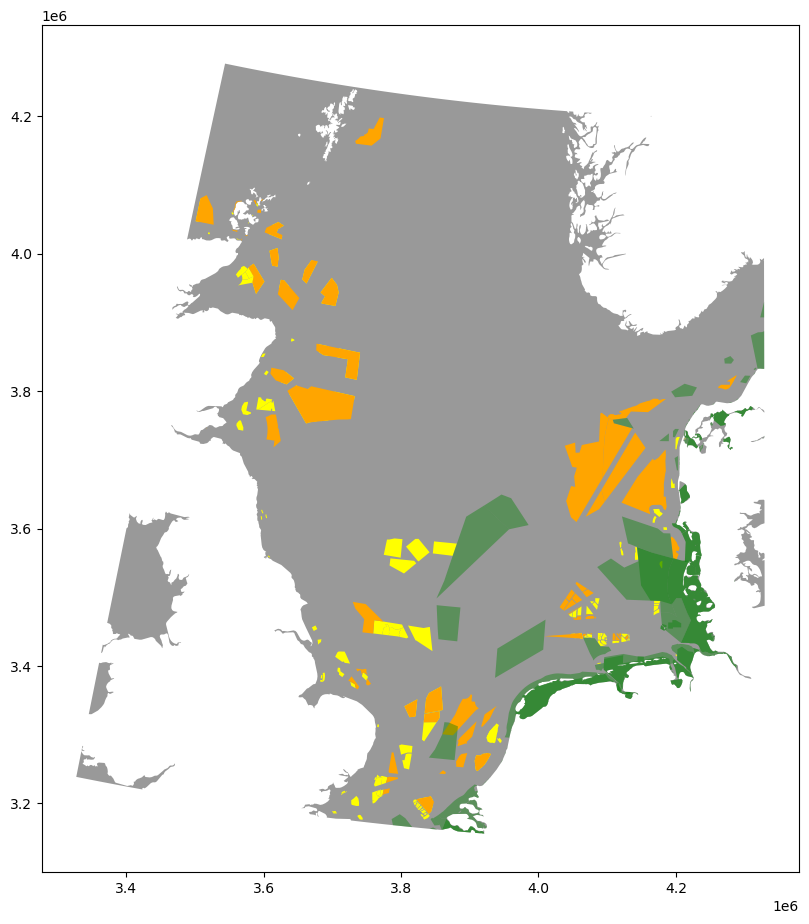

In [50]:

fig,ax =plt.subplots(1,figsize=(11,11))
n2000.plot(ax=ax,color='green',zorder=7, alpha=0.4)
#cutout.grid.to_crs(3035).plot(ax=ax,color='green',alpha=0.5)
#cells.to_crs(3035).plot(ax=ax,color='red',zorder=1,alpha=0.2)

coast3.plot(ax=ax,color='grey',zorder=0,alpha=0.8) #das shapefile der Wasserfläch einnerhalb des Cutouts
windfarm_new[(windfarm_new['STATUS']== 'Production') | (windfarm_new['STATUS']=='Approved') | (windfarm_new['STATUS']=='Construction')].to_crs(3035).plot(ax=ax, color='yellow')
#alternativ .isin() nutzen
windfarm_new[windfarm_new['STATUS']=='Planned'].to_crs(3035).plot(ax=ax, color='orange')

#coast2.to_crs(3035).plot(ax=ax)

#xmin,ymin,xmax,ymax =coast3.total_bounds.to_crs(3035)
#for axis in fig.get_axes():
#    axis.set_xlim(xmin,xmax)
#    axis.set_ylim(ymin,ymax)

In [51]:
#windfarm_new.index.astype("string")
windfarm_new.reset_index()
windfarm_map.reset_index();

windfarm_new.index =windfarm_new.index.astype("int64")
windfarm_new.index.dtype
windfarm_map.index.dtype

index  OBJECTID         COUNTRY              NAME  N_TURBINES  POWER_MW  \
0        0         8         Belgium            Rentel          42    309.00   
1        1         9         Belgium           Norther          44    370.00   
2        2        10         Belgium           Seastar          30    252.00   
3        3        11         Belgium           Mermaid          28    235.20   
4        4        12         Belgium  C-Power (Zone A)          24    141.15   
..     ...       ...             ...               ...         ...       ...   
199    199       300  United Kingdom               NE8           0      0.00   
200    200       301  United Kingdom               NE3           0      0.00   
201    201       302  United Kingdom               NE2           0      0.00   
202    202       305  United Kingdom                N1           0      0.00   
203    203       306  United Kingdom               NE1           0      0.00   

         STATUS  YEAR    COAST_DIST    AREA_SQKM NOTES  Shape_Leng  \
0    Production  2018  28354.728982    23.264154  None    0.260649   
1    Production  2018  19797.758680    38.445331  None    0.352805   
2    Production  2020  36085.954019    18.426179  None    0.222749   
3    Production  2020  48314.549431    16.676150  None    0.208196   
4    Production  2013  24793.536916    10.682070  None    0.174694   
..          ...   ...           ...          ...   ...         ...   
199     Planned  2020  74888.692695   338.514189  None    0.973250   
200     Planned  2020  36890.748999   264.507016  None    0.817893   
201     Planned  2020  11200.924116   345.204221  None    1.373264   
202     Planned  2020   3171.943583  1162.426770  None    1.817623   
203     Planned  2021  22486.088072   751.092432  None    1.793374   

     Shape_Area  0  \
0      0.003017  1   
1      0.004979  1   
2      0.002392  1   
3      0.002169  1   
4      0.001384  1   
..          ... ..   
199    0.051993  1   
200    0.040742  1   
201    0.053699  1   
202    0.181169  1   
203    0.121891  1   

                                                                                                                                                  geometry  
0    POLYGON ((2.90552 51.59822, 2.91429 51.59965, 2.93139 51.60670, 2.93972 51.61086, 2.95537 51.61985, 3.00353 51.59084, 2.99282 51.58800, 2.98329 51...  
1    POLYGON ((2.97331 51.48950, 2.93681 51.51286, 2.94508 51.51529, 2.97299 51.52806, 2.97883 51.53398, 2.98698 51.53413, 2.99118 51.53645, 2.99906 51...  
2    POLYGON ((2.84370 51.60708, 2.83087 51.60788, 2.81428 51.61465, 2.81934 51.61971, 2.83984 51.63631, 2.85773 51.65052, 2.86800 51.65772, 2.87846 51...  
3    POLYGON ((2.78949 51.71814, 2.78900 51.71771, 2.78857 51.71722, 2.78790 51.71661, 2.78748 51.71613, 2.75580 51.71063, 2.75513 51.71045, 2.71777 51...  
4                                   POLYGON ((2.90836 51.55810, 2.96208 51.53428, 2.93766 51.52309, 2.92797 51.52018, 2.88360 51.54680, 2.90836 51.55810))  
..                                                                                                                                                     ...  
199  POLYGON ((-1.06465 58.54189, -1.06962 58.53376, -1.07459 58.52563, -1.07956 58.51751, -1.08452 58.50938, -1.08948 58.50125, -1.09444 58.49312, -1....  
200  POLYGON ((-2.03549 58.50178, -2.03485 58.49302, -2.03421 58.48427, -2.03358 58.47551, -2.03294 58.46676, -2.03230 58.45800, -2.03166 58.44925, -2....  
201  POLYGON ((-2.06710 58.93342, -2.08003 58.92768, -2.09296 58.92193, -2.10588 58.91618, -2.11880 58.91043, -2.13172 58.90468, -2.14463 58.89893, -2....  
202  POLYGON ((-4.09759 59.12897, -4.08779 59.12218, -4.07800 59.11540, -4.06822 59.10861, -4.05844 59.10183, -4.04866 59.09504, -4.03889 59.08825, -4....  
203  POLYGON ((0.05023 60.52042, 0.04986 60.51173, 0.04950 60.50305, 0.04914 60.49436, 0.04878 60.48567, 0.04843 60.47699, 0.04807 60.46830, 0.04771 60...  

[204 rows x 15 columns]

index  OBJECTID         COUNTRY              NAME  N_TURBINES  POWER_MW  \
0        7         8         Belgium            Rentel          42    309.00   
1        8         9         Belgium           Norther          44    370.00   
2        9        10         Belgium           Seastar          30    252.00   
3       10        11         Belgium           Mermaid          28    235.20   
4       11        12         Belgium  C-Power (Zone A)          24    141.15   
..     ...       ...             ...               ...         ...       ...   
283    301       302  United Kingdom               NE2           0      0.00   
284    302       303  United Kingdom                N2           0      0.00   
285    303       304  United Kingdom                N3           0      0.00   
286    304       305  United Kingdom                N1           0      0.00   
287    305       306  United Kingdom               NE1           0      0.00   

         STATUS  YEAR    COAST_DIST    AREA_SQKM NOTES  Shape_Leng  \
0    Production  2018  28354.728982    23.264154  None    0.260649   
1    Production  2018  19797.758680    38.445331  None    0.352805   
2    Production  2020  36085.954019    18.426179  None    0.222749   
3    Production  2020  48314.549431    16.676150  None    0.208196   
4    Production  2013  24793.536916    10.682070  None    0.174694   
..          ...   ...           ...          ...   ...         ...   
283     Planned  2020  11200.924116   345.204221  None    1.373264   
284     Planned  2020  25449.639316   561.368731  None    1.711145   
285     Planned  2020   9457.333547  1106.353944  None    1.591722   
286     Planned  2020   3171.943583  1162.426770  None    1.817623   
287     Planned  2021  22486.088072   751.092432  None    1.793374   

     Shape_Area  \
0      0.003017   
1      0.004979   
2      0.002392   
3      0.002169   
4      0.001384   
..          ...   
283    0.053699   
284    0.087302   
285    0.172264   
286    0.181169   
287    0.121891   

                                                                                                                                                  geometry  
0    POLYGON ((2.88724 51.59085, 2.90552 51.59822, 2.91429 51.59965, 2.93139 51.60670, 2.93972 51.61086, 2.95537 51.61985, 3.00353 51.59084, 2.99282 51...  
1    POLYGON ((3.04002 51.51200, 2.97331 51.48950, 2.93681 51.51286, 2.94508 51.51529, 2.97299 51.52806, 2.97883 51.53398, 2.98698 51.53413, 2.99118 51...  
2    POLYGON ((2.86386 51.61521, 2.84370 51.60708, 2.83087 51.60788, 2.81428 51.61465, 2.81934 51.61971, 2.83984 51.63631, 2.85773 51.65052, 2.86800 51...  
3    POLYGON ((2.79057 51.71872, 2.78949 51.71814, 2.78900 51.71771, 2.78857 51.71722, 2.78790 51.71661, 2.78748 51.71613, 2.75580 51.71063, 2.75513 51...  
4                                   POLYGON ((2.88360 51.54680, 2.90836 51.55810, 2.96208 51.53428, 2.93766 51.52309, 2.92797 51.52018, 2.88360 51.54680))  
..                                                                                                                                                     ...  
283  POLYGON ((-2.05417 58.93917, -2.06710 58.93342, -2.08003 58.92768, -2.09296 58.92193, -2.10588 58.91618, -2.11880 58.91043, -2.13172 58.90468, -2....  
284  POLYGON ((-5.34445 58.80937, -5.34659 58.80182, -5.34874 58.79427, -5.35088 58.78671, -5.35303 58.77916, -5.35517 58.77161, -5.35731 58.76406, -5....  
285  POLYGON ((-6.32441 59.05853, -6.31226 59.05216, -6.30012 59.04578, -6.28798 59.03940, -6.27585 59.03303, -6.26373 59.02665, -6.25160 59.02027, -6....  
286  POLYGON ((-4.10739 59.13575, -4.09759 59.12897, -4.08779 59.12218, -4.07800 59.11540, -4.06822 59.10861, -4.05844 59.10183, -4.04866 59.09504, -4....  
287  POLYGON ((0.05059 60.52911, 0.05023 60.52042, 0.04986 60.51173, 0.04950 60.50305, 0.04914 60.49436, 0.04878 60.48567, 0.04843 60.47699, 0.04807 60...  

[288 rows x 14 columns]

dtype('int64')

dtype('int64')

clip setzt den Index auf Int 64, vorher rest.Index oder .index.astype(stirng) damit drop wieder funktioniert**
<br>
aus irgendeinem Grund eliminiert das Masking oben mit bool, dass Folium alles erkennt....
<br> deswegen hier mit overlay gearbeitet
aufpassen, dass das richtige CRS gesetzt ist, andernfalls landen einige Grenzwindparks wieder in der Auswahl (lillebk svylt), bei falschem CRS findet kein Clipping statt

https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html
m = data.eexplore()
other_data.add_to(m)

In [68]:
# import folium
nybb = geopandas.read_file(geopandas.datasets.get_path('nybb'))
#windfarm_map.explore()
#nybb.explore(column='BoroName')
#nybb.columns
#nybb.loc[:1].explore()
v= windfarm_map.clip(cells).overlay(poly_gdf_excl_west.to_crs(4326),how= 'difference').overlay(poly_gdf_excl_east.to_crs(4326),how= 'difference').explore(column='STATUS',cmap='jet')
n2000.overlay(coast3,how='intersection').overlay(poly_gdf_excl_east,how='difference').explore(m=v)

#cutout.grid.to_crs(3035).plot(ax=ax,color='green',alpha=0.5)
#cells.to_crs(3035).plot(ax=ax,color='red',zorder=1,alpha=0.2)


<GeoAxesSubplot:>

<GeoAxesSubplot:>

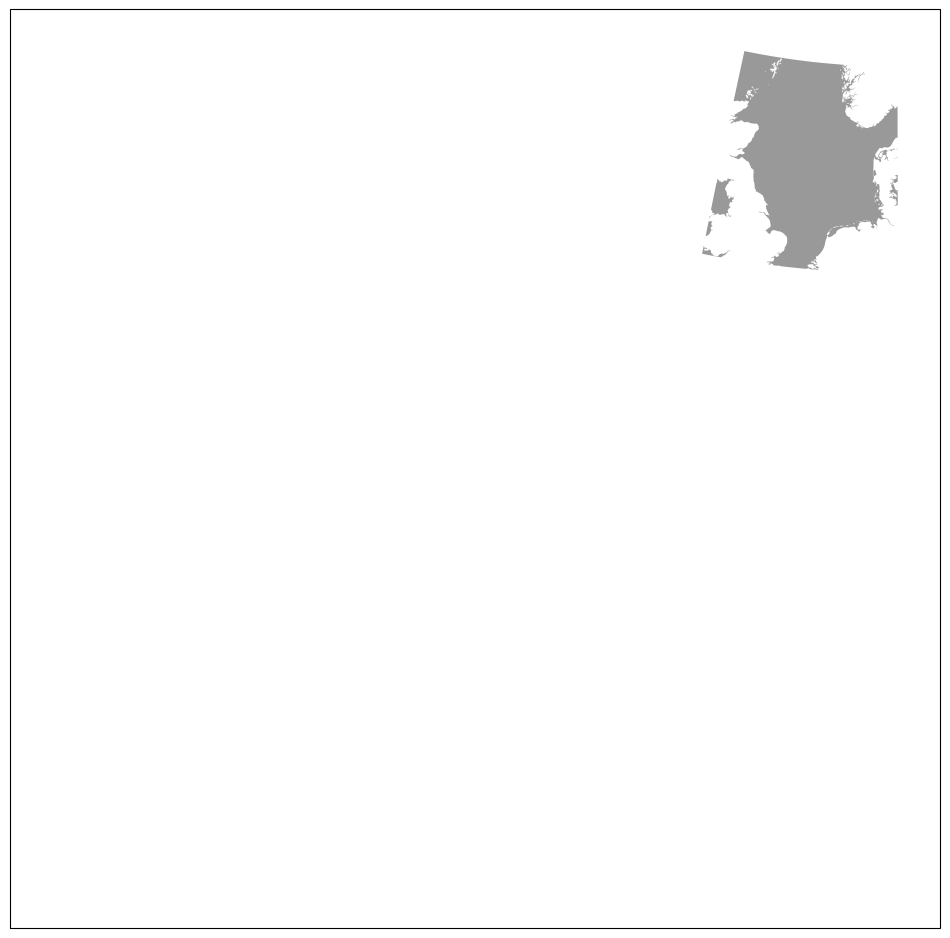

In [53]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection=ccrs.Mercator())
natura2000.to_crs(4326).plot(ax=ax,zorder=7)
#cutout.grid.to_crs(3035).plot(ax=ax,color='green',alpha=0.5)
#cells.to_crs(3035).plot(ax=ax,color='red',zorder=1,alpha=0.2)
coast3.plot(ax=ax,color='grey',zorder=0,alpha=0.8)



Clipping erfordert auch dasselbe crs


<AxesSubplot:>

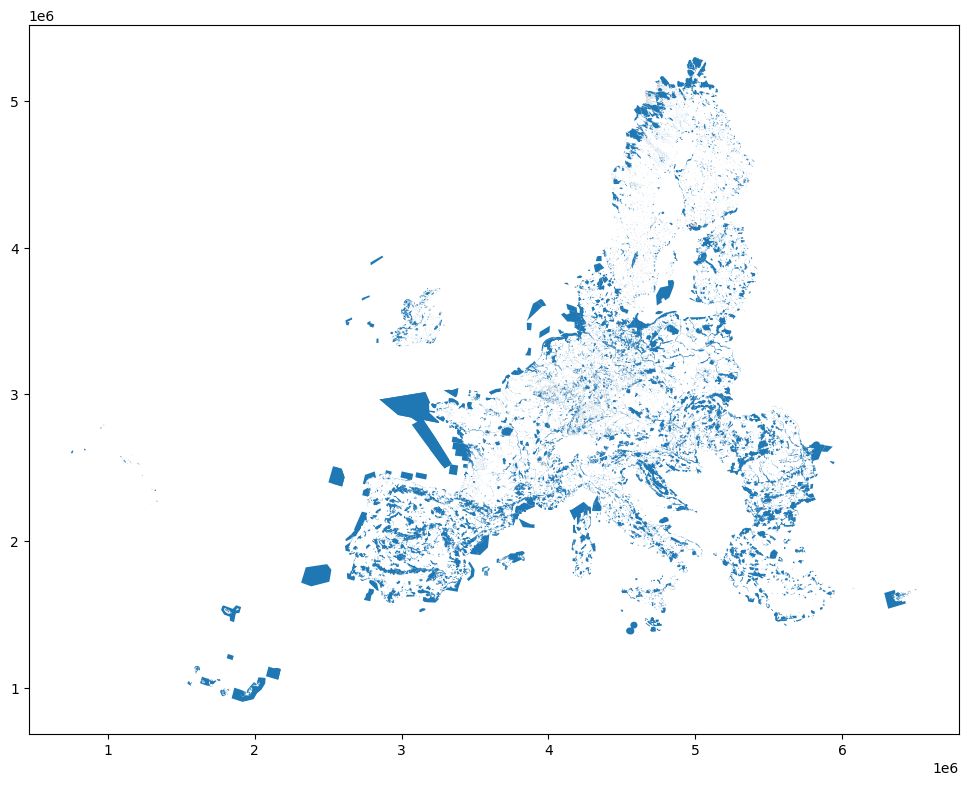

In [54]:
fig,ax =plt.subplots(1,figsize=(12,12))
natura2000.plot(ax=ax)

AttributeError: 'PatchCollection' object has no property 'projection'

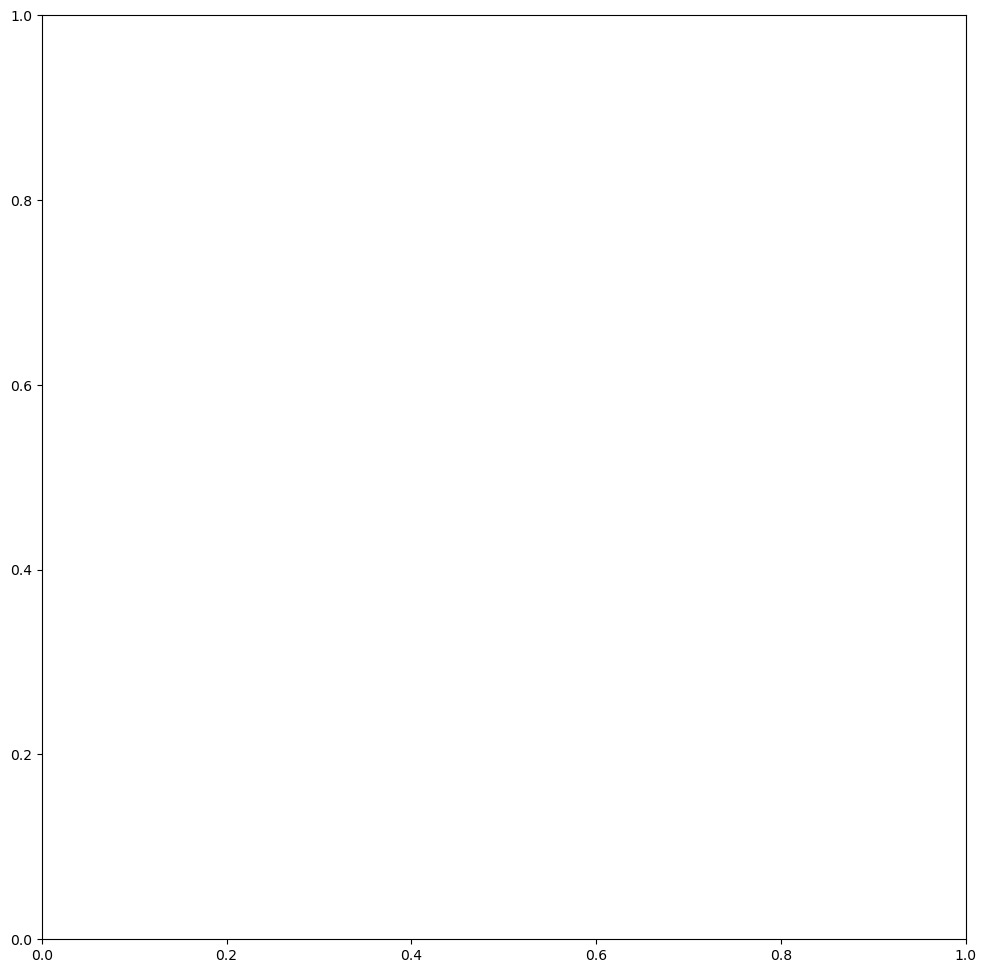

In [55]:
fig,ax =plt.subplots(1,figsize=(12,12))
natura2000.plot(ax=ax,projection= ccrs.EqualEarth())

#https://matplotlib.org/stable/tutorials/colors/colormapnorms.html
#rasterio with colorbar
#https://stackoverflow.com/questions/61327088/rio-plot-show-with-colorbar



In [ ]:
cells.crs

Exclusion Container
- Natura 2000 https://www.eea.europa.eu/data-and-maps/data/natura-14/natura-2000-spatial-data/inspire-compliant-metadata-set
https://www.eea.europa.eu/data-and-maps/data/natura-14
https://natura2000.eea.europa.eu/

- Sperrgebite
- Bathymetry GEBCO Datensatz


zuordnung raster zu gEookoordinaten? grade 0 bis 250000